In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import windrose
from datetime import datetime
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from windrose import WindroseAxes
import matplotlib.cm as cm
import matplotlib.ticker as tkr

General parameters

## Notebook workflow (recommended)

1. **Set parameters**: study location, depth limits, and thresholds.
2. **Load datasets**: currents, waves, and wind (NetCDF/CSV).
3. **Pre-process**: quality control, resampling (hourly/daily), and unit checks.
4. **Compute extremes**: percentile thresholds (e.g., 95th/99th) and event counts.
5. **Visualize**: time series, histograms, and rose plots (all labels in English).
6. **Export**: save figures and (optionally) summary tables.


In [2]:
# cordendas do ponto central
lat = -25.456
lon = -43.089

# latitude e longitude aproximadas da isóbata de 1000m no litoral de SC
sc_isobata_1000m = (-46, -26) # lon , lat
# lat e long talude bacia de santos
bacia_santos_talude = (-42.5, -23.5) # lon , lat

# definindo limite de profundidade

max_depth = 15  # profundidade em metros

# Environmental patterns (2016–2024)

## Currents

### Generating current data for the delimited study area

In [3]:
# # importando dados de corrente

# current_speed_ds = (
#     xr.open_dataset("D:/SARC_LISA_2024/01_dados_brutos/dados_de_reanalise/02_parametros_fisicos/corrente_waverys_AS_1979_2024/glorys_sarc.nc")
#     .sel(time=slice(datetime(2016, 1, 1), datetime(2024, 12, 31)))
#     .sel(latitude= lat, longitude=lon, method='nearest')
#     .sel(depth=max_depth, method='nearest')
# )

# # calculo da speed e direction da corrente
# u = current_speed_ds['uo'].values
# v = current_speed_ds['vo'].values

# current_speed = np.sqrt(u**2 + v**2)

# current_direction = (90 -(np.arctan2(v, u) * (180 / np.pi)) )% 360
# current_15m_df = pd.DataFrame({
#     'time': current_speed_ds['time'].values,
#     'current_speed': current_speed,
#     'current_direction': current_direction
# })

# # current_15m_df.to_csv("D:/SARC_LISA_2024/01_dados_brutos/dados_processados/corrente_waverys_AS_15m_2016_2024.csv")

### Case 2: data import

In [4]:
# importando dados
current_15m_df = pd.read_csv("D:/SARC_LISA_2024/01_dados_brutos/dados_processados/corrente_waverys_AS_15m_2016_2024.csv")
current_15m_df.set_index('time', inplace=True)

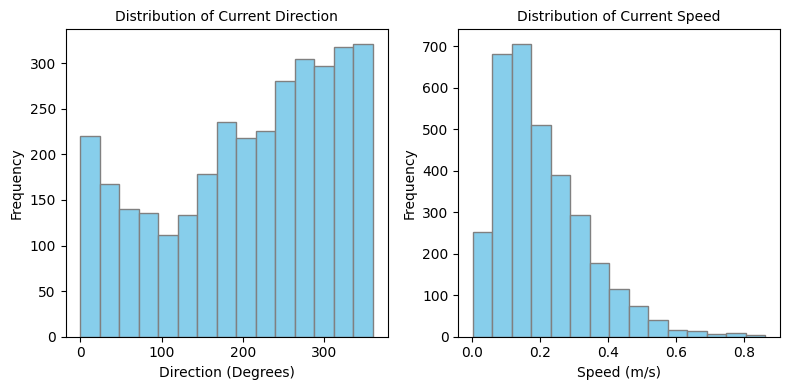

In [5]:
# plot distribuição de dados de direction e magnitude

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
# plot 1 : Current Direction
ax1.hist(current_15m_df['current_direction'], bins =15, color='skyblue', edgecolor = 'gray')
ax1.set_title('Distribution of Current Direction', fontsize=10)
ax1.set_xlabel('Direction (Degrees)', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)

# plot 2 : Current Speed
ax2.hist(current_15m_df['current_speed'], bins=15, color='skyblue', edgecolor= 'gray')
ax2.set_title('Distribution of Current Speed', fontsize=10)
ax2.set_xlabel('Speed (m/s)', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)

# Optimization
plt.tight_layout() # Prevents labels from overlapping
plt.show()

Text(0.5, 1.0, 'Current rose: speed and direction (2016–2024)')

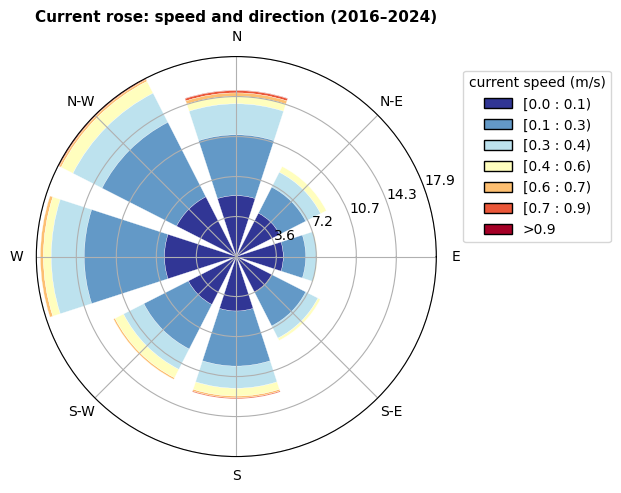

In [6]:
# plot diagrama rosa de corrente
fig = plt.figure(figsize=(5,5))

ax = WindroseAxes.from_ax(fig=fig)
# ax.set_theta_zero_location("N")
# ax.set_theta_direction(-1)

ax.bar(current_15m_df['current_direction'], current_15m_df['current_speed'], # direction, magnitude
        normed=True, bins = 7, nsector=8,
        cmap = plt.get_cmap('RdYlBu_r'), # color scheeme
        edgecolor = 'white', lw=0.2) # add a line between blocks, for clarity

ax.tick_params(axis='both', which='major', labelsize=10)
ax.legend(title = "current speed (m/s)",
          loc= 'center left', 
          decimal_places=1,
          bbox_to_anchor=(1.05, 0.75),
          fontsize=10)

ax.set_rlabel_position(20)

plt.title("Current rose: speed and direction (2016–2024)", fontsize=11, weight = 'bold')


### Computing extremes for current speed

In [7]:
# filtrar dados para speed acima de quartil 95
# cálculo do 95º percentil
q95 = current_15m_df['current_speed'].quantile(0.95) 
# filtrando os dados
strong_currents_df = current_15m_df[current_15m_df['current_speed'] >= q95]
# set indexes
strong_currents_df.index = pd.to_datetime(strong_currents_df.index)
current_15m_df.index = pd.to_datetime(current_15m_df.index)

In [8]:
# estatísticas de extremes de corrente
max_c_velocity = strong_currents_df['current_speed'].max() # speed máxima
min_c_velocity = strong_currents_df['current_speed'].min() # speed mínima

diferenca_c_velocity = max_c_velocity - min_c_velocity # diferença entre max e min

print(f"Quantidade de dados de corrente fortes (acima do quartil 95): {len(strong_currents_df)}")
print(f"Velocidade máxima da corrente (m/s): {max_c_velocity}")
print(f"Velocidade mínima da corrente (m/s): {min_c_velocity}")
print(f"Diferença entre speed máxima e mínima da corrente (m/s): {diferenca_c_velocity}")


Quantidade de dados de corrente fortes (acima do quartil 95): 165
Velocidade máxima da corrente (m/s): 0.86397765494524
Velocidade mínima da corrente (m/s): 0.4600624557084416
Diferença entre speed máxima e mínima da corrente (m/s): 0.4039151992367984


Text(0.5, 1.0, 'Current extremes: speed and direction (2016–2024)')

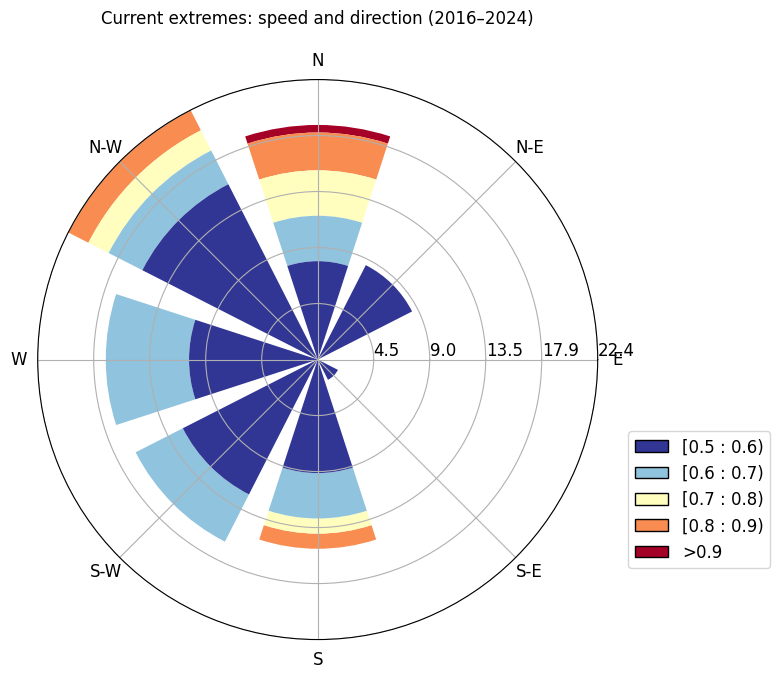

In [9]:
# plotando rosa dos ventos para extremes de corrente

fig = plt.figure(figsize=(7,7))
right_rectangle = [0,0,0.8,0.8] # [left, bottom, width, height]
ax = WindroseAxes(fig, right_rectangle)
fig.add_axes(ax)

ax.bar(strong_currents_df['current_direction'], strong_currents_df['current_speed'], # direction, magnitude
        normed=True, bins = 5, nsector=8,
        cmap = plt.get_cmap('RdYlBu_r')) 

ax.tick_params(axis='both', which='major', labelsize=12)
# configuration dos labels radiais e da legend
ax.legend(loc= 'center left', decimal_places=1,
          bbox_to_anchor=(1.04, 0.25), fontsize=12)

ax.set_rlabel_position(0) # posição dos labels radiais

plt.title("Current extremes: speed and direction (2016–2024)",pad= 20, fontsize=12)

Text(0, 0.5, 'Current speed (m/s)')

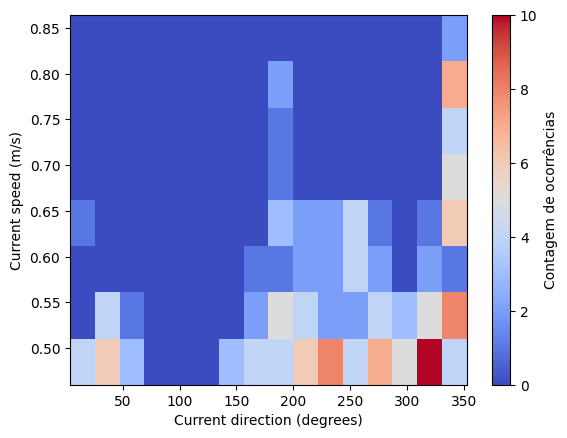

In [10]:
plt.hist2d(strong_currents_df['current_direction'], strong_currents_df['current_speed'],
           bins=[16, 8],
           cmap='coolwarm'
              )
plt.colorbar(label='Contagem de ocorrências')
plt.xlabel('Current direction (degrees)')
plt.ylabel('Current speed (m/s)')

In [11]:
# calcular direction média de vento por estação
summer_months = [1,2,3]
c_summer = strong_currents_df[strong_currents_df.index.month.isin(summer_months)]

autumn_months = [4, 5, 6]
c_autumn = strong_currents_df[strong_currents_df.index.month.isin(autumn_months)]

winter_months = [7, 8, 9]
c_winter = strong_currents_df[strong_currents_df.index.month.isin(winter_months)]

spring_months = [10, 11, 12]
c_spring = strong_currents_df[strong_currents_df.index.month.isin(spring_months)]


In [12]:
def define_season(date):
    m = date.month
    d = date.day

    if (m == 12 and d >= 21) or (m < 3) or (m == 3 and d < 20):
        return 'summer'      # Verão
    elif (m == 3 and d >= 20) or (m < 6) or (m == 6 and d < 21):
        return 'autumn'      # Outono
    elif (m == 6 and d >= 21) or (m < 9) or (m == 9 and d < 23):
        return 'winter'      # Inverno
    else:
        return 'spring'      # Primavera

strong_currents_df['season'] = strong_currents_df.index.to_series().apply(define_season)

c_summer = strong_currents_df[strong_currents_df['season'] == 'summer']
c_autumn = strong_currents_df[strong_currents_df['season'] == 'autumn']
c_winter = strong_currents_df[strong_currents_df['season'] == 'winter']
c_spring = strong_currents_df[strong_currents_df['season'] == 'spring']



C:\Users\locfa\AppData\Local\Temp\ipykernel_29212\2293194649.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strong_currents_df['season'] = strong_currents_df.index.to_series().apply(define_season)


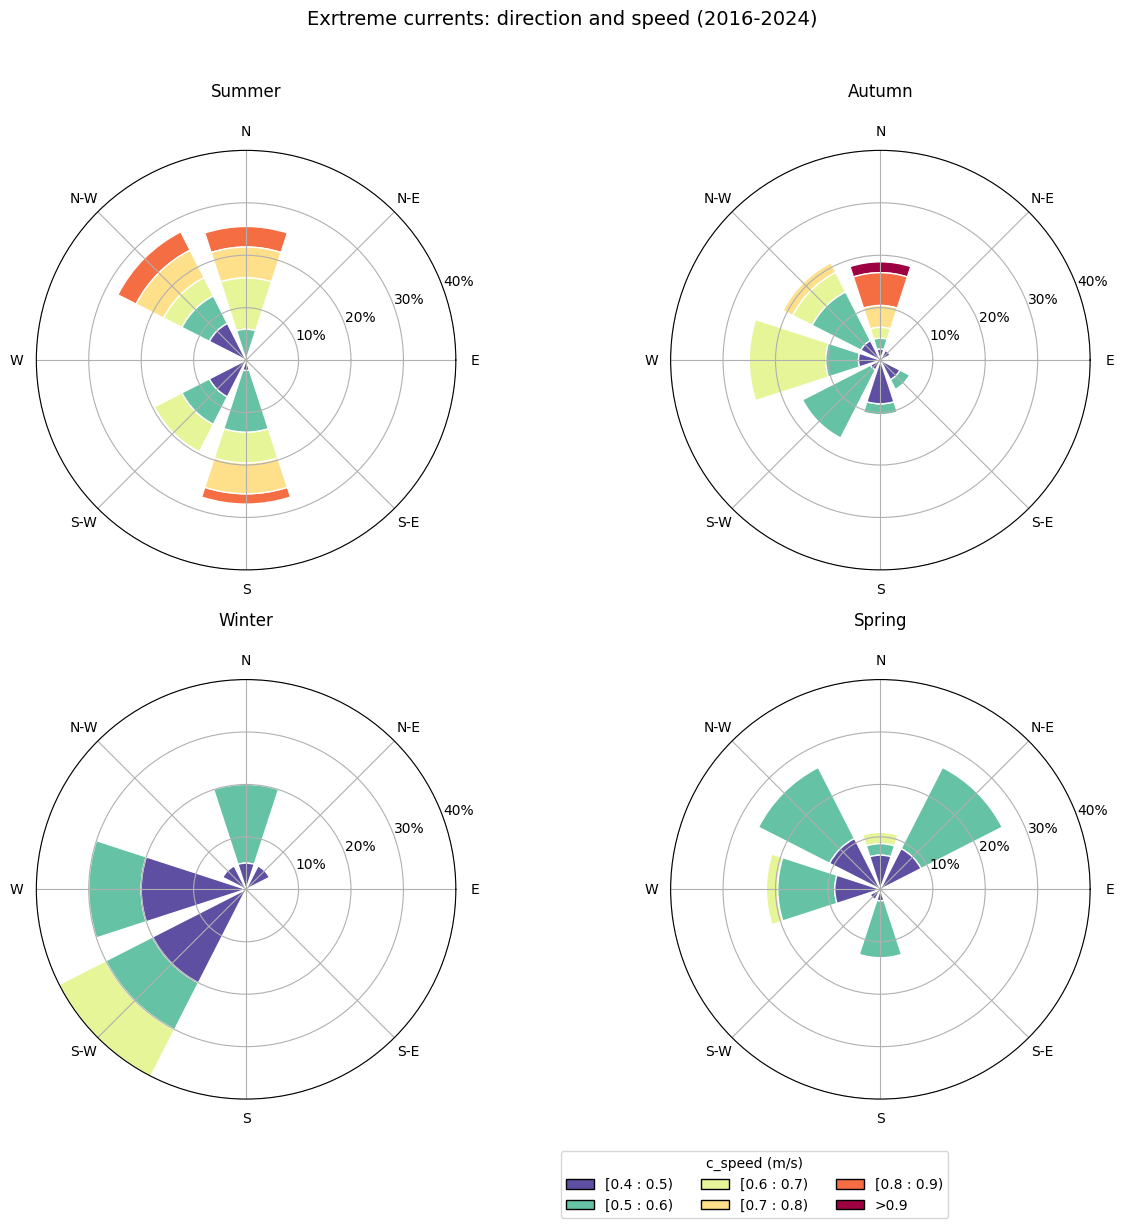

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), subplot_kw=dict(projection='windrose'))

seasons = {'Summer': c_summer, 'Autumn': c_autumn, 'Winter': c_winter, 'Spring': c_spring}
bins = np.linspace(min_c_velocity-0.06, max_c_velocity, num=6)

# --- CONFIGURAÇÃO DE PADRONIZAÇÃO ---
# Defina o valor máximo da escala radial (ex: 25%)
r_max_limit = 40 
# Defina onde os círculos (grids) devem aparecer
r_ticks = [10, 20, 30, 40]

for i, (season, data) in enumerate(seasons.items()):
    ax = axes.flatten()[i]
    
    ax.bar(data['current_direction'], data['current_speed'],
           bins=bins,
           normed=True, # Garante que o cálculo seja em porcentagem
           nsector=8,
           edgecolor='white', 
           cmap=cm.Spectral_r)
    
    ax.set_title(season, fontsize=12, pad=20)
    
    # Padronização da escala radial
    ax.set_ylim(0, r_max_limit) # Força todos os eixos a terem o mesmo tamanho
    ax.set_yticks(r_ticks)      # Força as mesmas linhas de grade
    
    # Formatação dos labels
    ax.set_rlabel_position(20)
    ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%2.0f%%')) # Adiciona o símbolo de %

# Legend adjustment (moved outside to avoid overlap)
axes.flatten()[-1].legend(title="c_speed (m/s)", 
                         loc='lower center', 
                         bbox_to_anchor=(0.2, -0.3), 
                         ncol=3)

fig.suptitle('Exrtreme currents: direction and speed (2016-2024)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [14]:
for s in seasons:
    print(f"{s} - Máxima speed da corrente (m/s): {seasons[s]['current_speed'].max()}")

Summer - Máxima speed da corrente (m/s): 0.7971771158717851
Autumn - Máxima speed da corrente (m/s): 0.86397765494524
Winter - Máxima speed da corrente (m/s): 0.634296806080701
Spring - Máxima speed da corrente (m/s): 0.6459253879790632


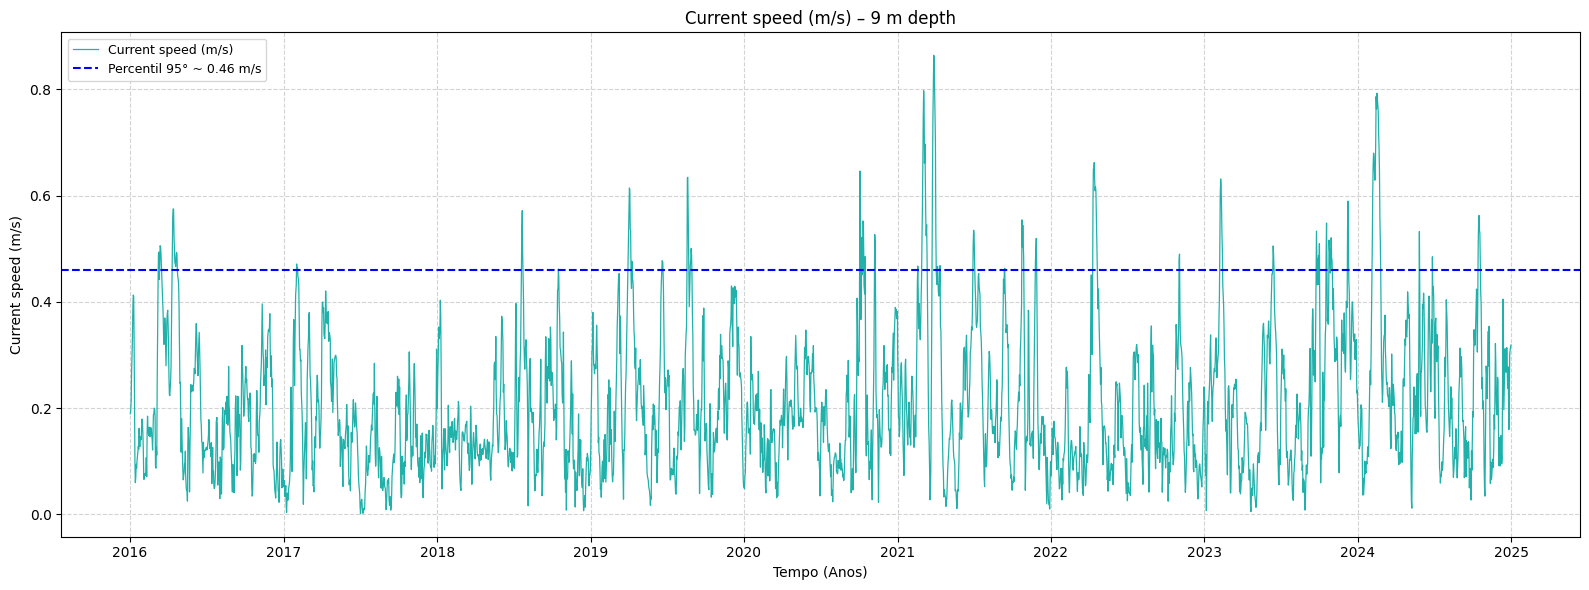

In [15]:
# Plot the current speed time series
plt.figure(figsize=(16, 6))
plt.plot(current_15m_df.index, current_15m_df['current_speed'], label='Current speed (m/s)', color='lightseagreen', linewidth=0.9)
#plt.plot(currents_df_9m.index, currents_df_9m['current_speed_9m'], label='Current Speed at 9m Depth', color='orange')
plt.axhline(y=q95, color='blue', linestyle='--', label=f'Percentil 95° ~ {q95:.2f} m/s')
# plt.axhline(y=q99_9m, color='red', linestyle='--', label=f'Percentil 99° ~ {q99_9m:.2f} m/s')
plt.title('Current speed (m/s) – 9 m depth')
plt.xlabel('Tempo (Anos)')
plt.ylabel('Current speed (m/s)')
plt.grid(
    linestyle = '--',
    color = 'lightgray'
)
plt.legend(loc = 'upper left',
        #    bbox_to_anchor = (1,1.2),
           fontsize = 9)
plt.tight_layout()

In [16]:
# quantificar quantas vezes a variável ultrapassou o limiar
print(f'o valor do percentil 95 é {q95}')
print(f'a variável de speed do corrente ultrapassou {len(current_15m_df[current_15m_df['current_speed']>q95])} vezes')
print(f'o valor máximo de speed de corrente foi de {current_15m_df['current_speed'].max()}')
print(f' isso representa {165/3288*100} % dos dias')
# data na qual foi registrado o maior valor diário de speed de corrente
print(f'data na qual foi registrado o maior valor diário de speed de corrente : {current_15m_df['current_speed'].idxmax()}')

o valor do percentil 95 é 0.4597178675538908
a variável de speed do corrente ultrapassou 165 vezes
o valor máximo de speed de corrente foi de 0.86397765494524
 isso representa 5.018248175182482 % dos dias
data na qual foi registrado o maior valor diário de speed de corrente : 2021-03-28 00:00:00


### Functions to plot bar charts quantifying points above a defined threshold

In [17]:
def plot_extreme_events(df, var, quantile, var_label):
    # 1. Filtragem dos dados extremes
    extreme_values = df[df[var] > quantile]
    
    # 2. Agrupamentos
    extreme_by_month = extreme_values.groupby(extreme_values.index.month).count()
    extreme_by_year = extreme_values.groupby(extreme_values.index.year).count()
    
    # 3. Configuração da Figura (1 linha, 2 colunas)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    month_label = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez']

    # --- SUBPLOT 1: MENSAL ---
    bars1 = ax1.bar(extreme_by_month.index, extreme_by_month[var].values, color='steelblue', width=0.8)
    ax1.set_title(f'Eventos de {var_label} por Mês', fontsize=12, weight='bold')
    ax1.set_xlabel('Mês')
    ax1.set_ylabel('Quantidade de Ocorrências')
    ax1.set_xticks(extreme_by_month.index)
    ax1.set_xticklabels([month_label[i-1] for i in extreme_by_month.index])
    ax1.grid(axis='y', linestyle="--", color="lightgray", alpha=0.7)

    # --- SUBPLOT 2: ANUAL ---
    bars2 = ax2.bar(extreme_by_year.index, extreme_by_year[var].values, color='steelblue', width=0.8)
    ax2.set_title(f'Eventos de {var_label} por Ano', fontsize=12, weight='bold')
    ax2.set_xlabel('Ano')
    ax2.set_xticks(extreme_by_year.index)
    ax2.grid(axis='y', linestyle="--", color="lightgray", alpha=0.7)

    # 4. Função auxiliar para adicionar labels numéricos sobre as barras
    def add_labels(ax, bars):
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + (yval*0.01), 
                    int(yval), ha='center', va='bottom', fontsize=10)

    add_labels(ax1, bars1)
    add_labels(ax2, bars2)

    # 5. Ajustes finais
    fig.suptitle(f'Análise de Valores Extremos: {var_label} (Quantil > {quantile:.2f}) m/s', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

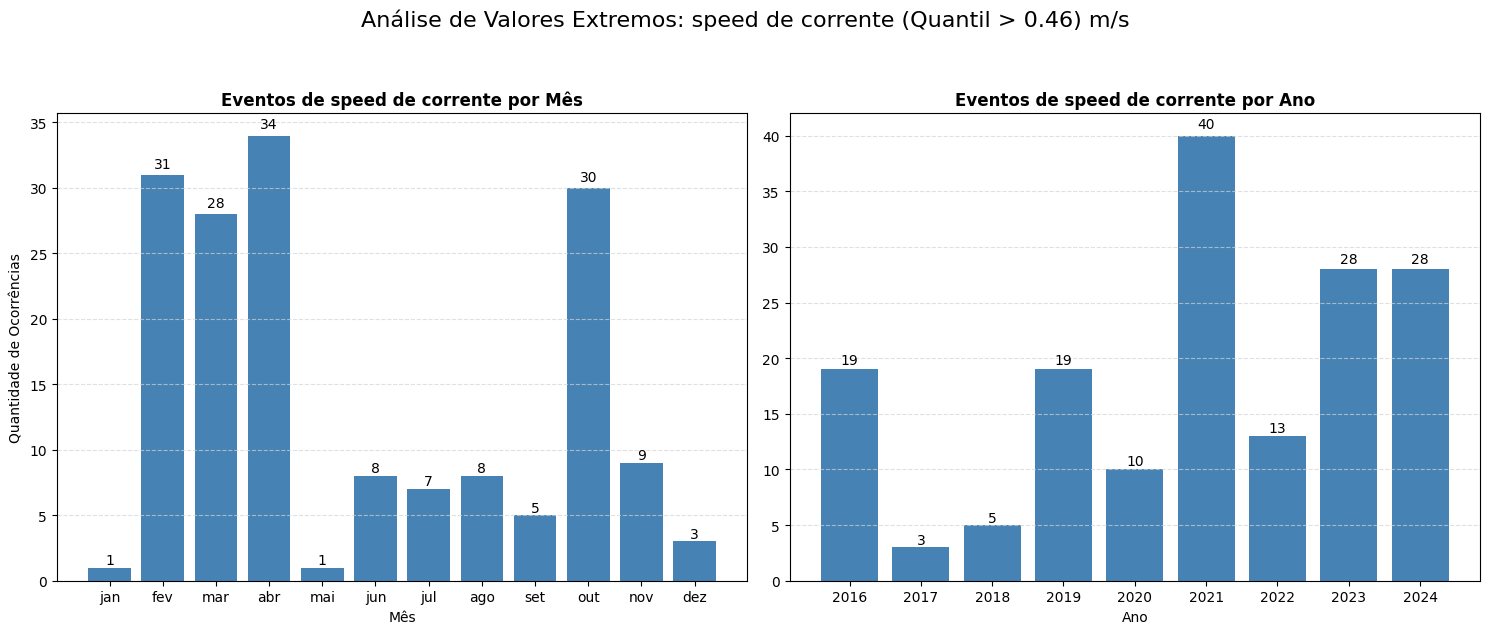

In [18]:
plot_extreme_events(current_15m_df, 'current_speed', q95, 'speed de corrente')

## Significant Wave Height

In [19]:
#import wave dataset
wave_height_ds = xr.open_dataset("D:/SARC_LISA_2024/01_dados_brutos/dados_de_reanalise/02_parametros_fisicos/centroid_point_data/wave_height_2016_2024/reanalysis-era5-single-levels-timeseries-wavdj3m5fj6.nc")

# Define variables
Hs = wave_height_ds.swh
wave_direction = wave_height_ds.mwd

Hs = pd.DataFrame(Hs.values, index=Hs.valid_time.values, columns=['wave_height'])
wave_direction = pd.DataFrame(wave_direction.values, index=wave_direction.valid_time.values, columns=['wave_direction'])
Hs['wave_direction'] = wave_direction['wave_direction']

In [20]:
# define 95 and 99 quartiles
q95_Hs = Hs['wave_height'].quantile(0.95)
q99_Hs = Hs['wave_height'].quantile(0.99)
q99_9_Hs = Hs['wave_height'].quantile(0.999)
print(f"95th percentile of wave height: {q95_Hs}")
print(f"99th percentile of wave height: {q99_Hs}")

95th percentile of wave height: 3.1518387198448177
99th percentile of wave height: 3.941490573883056


In [21]:
print(f'o número de dados que ultrapassaram o limiar de {q99_Hs} foi de {len(Hs[Hs["wave_height"]>q99_Hs])}')
print(f'o maior valor registrado foi de {Hs["wave_height"].max()}')
print(f'o menor valor registrado foi de {Hs["wave_height"].min()}')

o número de dados que ultrapassaram o limiar de 3.941490573883056 foi de 790
o maior valor registrado foi de 6.079657077789307
o menor valor registrado foi de 0.728531002998352


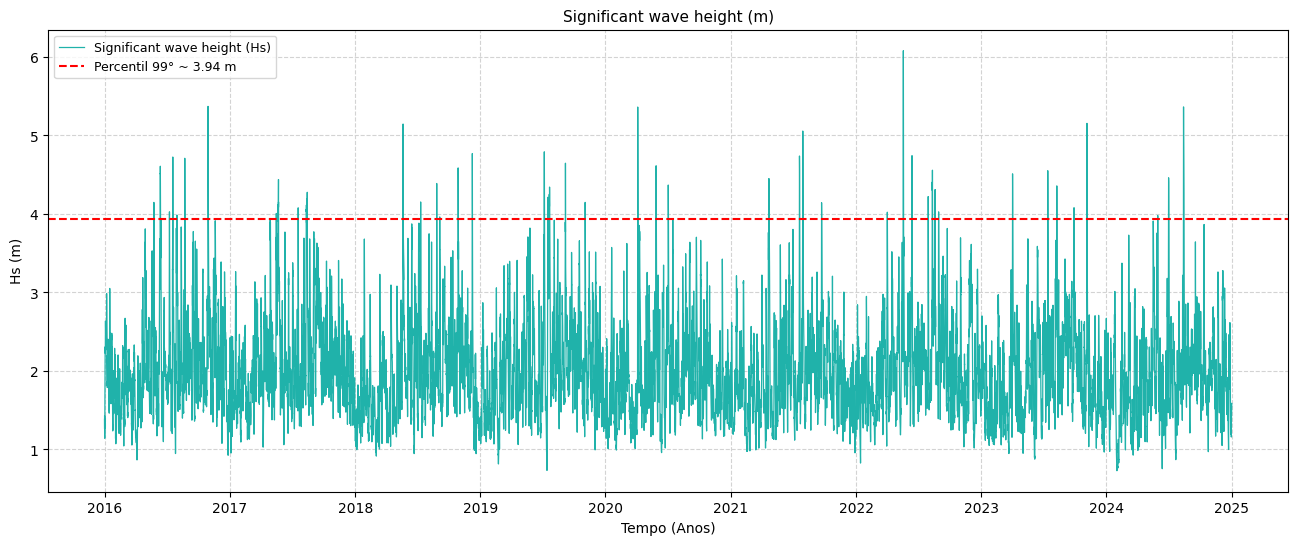

In [22]:
# plot wave height time series
plt.figure(figsize=(16,6))
plt.plot(Hs.index, Hs['wave_height'], label='Significant wave height (Hs)', color='lightseagreen', linewidth=0.9)
# plt.axhline(y=q95_Hs, color='blue', linestyle='--', label=f'Percentil 95° ~ {q95_Hs:.2f} m')
plt.axhline(y=q99_Hs, color='red', linestyle='--', label=f'Percentil 99° ~ {q99_Hs:.2f} m')
plt.title('Significant wave height (m)', fontsize = 11)
plt.xlabel('Tempo (Anos)', fontsize = 10)
plt.ylabel('Hs (m)', fontsize = 10)

plt.legend(
    loc='upper left',
    # bbox_to_anchor=(1.19, 1.02),
    fontsize= 9
)
plt.grid(
    which='both',
    linestyle='--',
    color='lightgray'
)

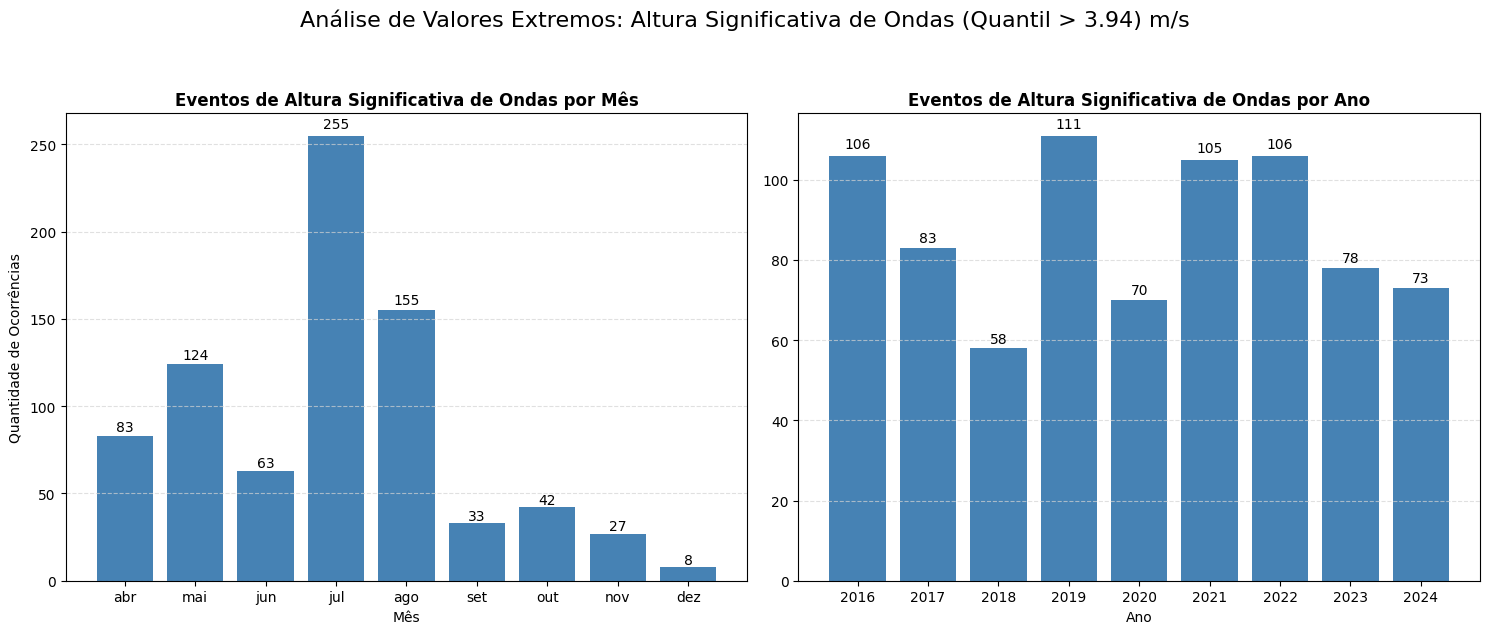

In [23]:
plot_extreme_events(Hs, 'wave_height', q99_Hs, "Altura Significativa de Ondas")

### Rose plot

In [24]:
max_wave_h = Hs['wave_height'].max()
min_wave_h = Hs['wave_height'].min()
max_wave_h - min_wave_h

np.float32(5.351126)

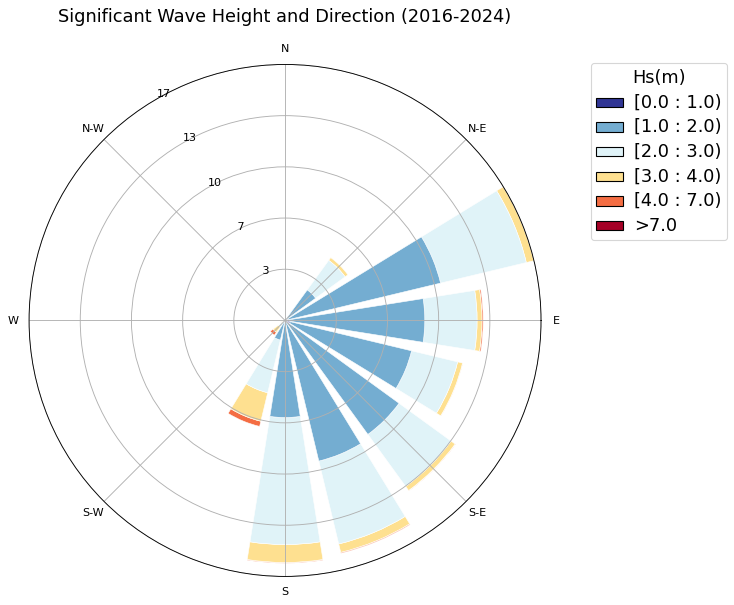

In [25]:
# Wind rose plot for wave direction and height
ax = windrose.WindroseAxes.from_ax(figsize=(8, 8))

# Define bins for wave height
wave_bins = [0, 1, 2, 3, 4, np.ceil(Hs['wave_height'].max())]
wave_labels = ['0-1', '1-2', '2-3', '3-4', '4-5', '>5']

ax.bar(
    Hs['wave_direction'],
    Hs['wave_height'],
    bins=wave_bins,
    nsector=16,
    normed=True,
    opening=0.8,
    edgecolor='white',
    linewidth=0.5,
    cmap=plt.cm.RdYlBu_r
)

legend = ax.set_legend(title='Hs(m)',
              loc='upper right', 
              bbox_to_anchor=(1.36, 1), 
              labels=wave_labels,
              fontsize=12)
# Ajustar título
plt.setp(legend.get_title(), fontsize=16)
# Ajustar labels
for text in legend.get_texts():
    text.set_fontsize(16)
ax.set_rlabel_position(120)
ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%2.0f'))
ax.set_title('Significant Wave Height and Direction (2016-2024)', pad=20, fontsize=16)
# ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
plt.show()

In [26]:
# criando dataframe para valores extremes

extreme_waves_df = Hs[Hs['wave_height'] > q99_Hs]
min_wave_h = extreme_waves_df['wave_height'].min()
max_wave_h = extreme_waves_df['wave_height'].max()

print(f'valor mínimo de altura de ondas em extremes: {min_wave_h}')

valor mínimo de altura de ondas em extremes: 3.9415643215179443


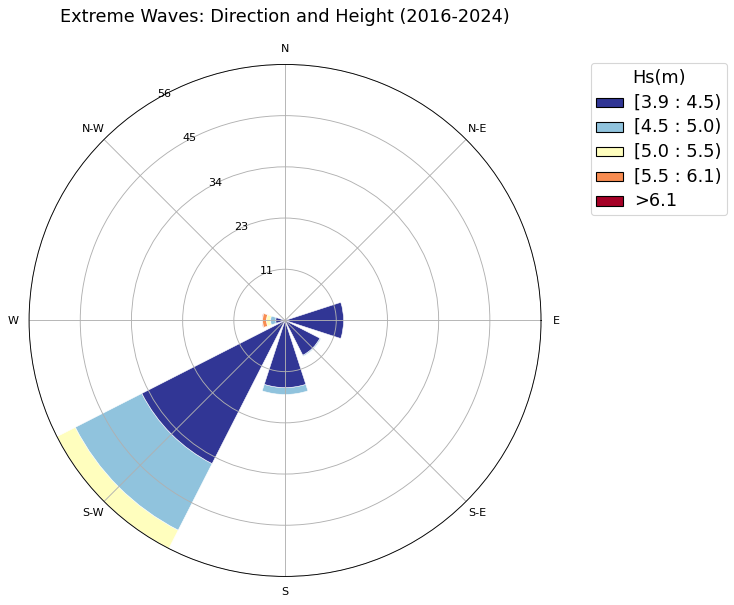

In [27]:
# Wind rose plot for wave direction and height
ax = windrose.WindroseAxes.from_ax(figsize=(8, 8))


ax.bar(
    extreme_waves_df['wave_direction'],
    extreme_waves_df['wave_height'],
    bins=5,
    nsector=8,
    normed=True,
    opening=0.8,
    edgecolor='white',
    linewidth=0.5,
    cmap=plt.cm.RdYlBu_r
)

legend = ax.set_legend(title='Hs(m)',
              loc='upper right', 
              bbox_to_anchor=(1.36, 1), 
              labels=wave_labels,
              fontsize=12)

# Ajustar título
plt.setp(legend.get_title(), fontsize=16)

# Ajustar labels
for text in legend.get_texts():
    text.set_fontsize(16)
ax.set_rlabel_position(120)
ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%2.0f'))
ax.set_title('Extreme Waves: Direction and Height (2016-2024)', pad=20, fontsize=16)
# ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
plt.show()

In [28]:
def define_season(date):
    m = date.month
    d = date.day

    if (m == 12 and d >= 21) or (m < 3) or (m == 3 and d < 20):
        return 'summer'      # Verão
    elif (m == 3 and d >= 20) or (m < 6) or (m == 6 and d < 21):
        return 'autumn'      # Outono
    elif (m == 6 and d >= 21) or (m < 9) or (m == 9 and d < 23):
        return 'winter'      # Inverno
    else:
        return 'spring'      # Primavera


In [29]:
extreme_waves_df['season'] = extreme_waves_df.index.map(define_season)

C:\Users\locfa\AppData\Local\Temp\ipykernel_29212\3737616635.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_waves_df['season'] = extreme_waves_df.index.map(define_season)


In [30]:
wave_summer = extreme_waves_df[extreme_waves_df['season'] == 'summer']
wave_autumn = extreme_waves_df[extreme_waves_df['season'] == 'autumn']
wave_winter = extreme_waves_df[extreme_waves_df['season'] == 'winter']
wave_spring = extreme_waves_df[extreme_waves_df['season'] == 'spring']


In [31]:
seasons = {'Autumn': wave_autumn, 'Winter': wave_winter, 'Spring': wave_spring}
for s in seasons:
    print(f"{s} - Máxima altura de onda (m): {seasons[s]['wave_height'].max()}")
    print(f"{s} - Mínima altura de onda (m): {seasons[s]['wave_height'].min()}")

Autumn - Máxima altura de onda (m): 6.079657077789307
Autumn - Mínima altura de onda (m): 3.9419615268707275
Winter - Máxima altura de onda (m): 5.363559722900391
Winter - Mínima altura de onda (m): 3.9415643215179443
Spring - Máxima altura de onda (m): 5.370546340942383
Spring - Mínima altura de onda (m): 3.9602582454681396


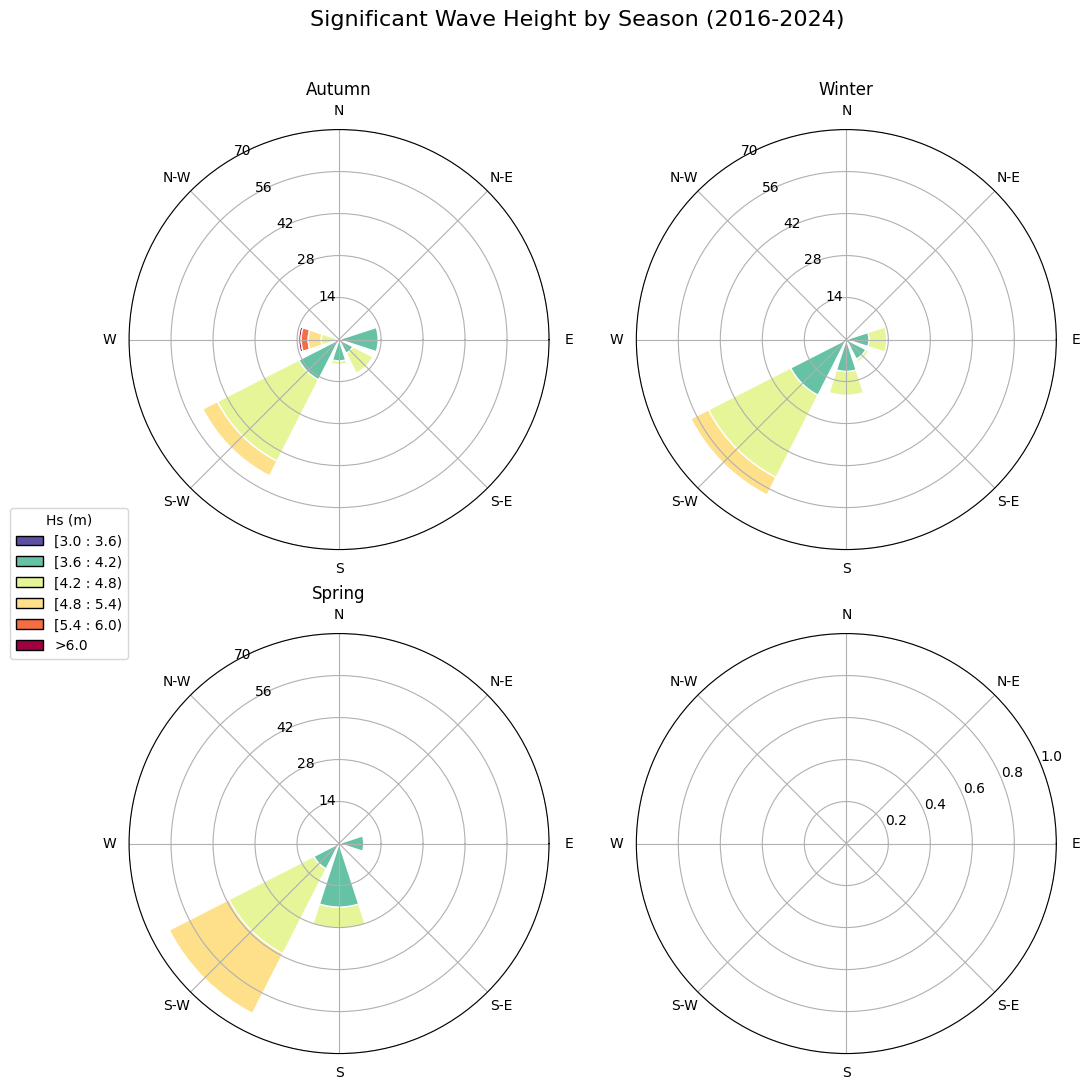

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), subplot_kw=dict(projection='windrose'))

wave_bins = np.linspace(3, 6, num=6)

# --- CONFIGURAÇÃO DE PADRONIZAÇÃO ---
# Defina o valor máximo da escala radial (ex: 25%)
r_max_limit = 70
# Defina onde os círculos (grids) devem aparecer
r_ticks = [14, 28, 42, 56, 70]


for i, (season, data) in enumerate(seasons.items()):
    ax = axes.flatten()[i]
    ax.bar(data['wave_direction'], data['wave_height'],
           normed=True,
           bins=wave_bins,
           nsector=8,
           edgecolor='white', 
           cmap=cm.Spectral_r)
    
    # Padronização da escala radial
    ax.set_ylim(0, r_max_limit) # Força todos os eixos a terem o mesmo tamanho
    ax.set_yticks(r_ticks)      # Força as mesmas linhas de grade

    # title
    ax.set_title(season, fontsize=12)
    ax.set_rlabel_position(120)
    ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%2.0f'))

# Add a single legend to the last subplot
ax.legend(title="Hs (m)", loc='center left', bbox_to_anchor=(-0.3, 1.12))

fig.suptitle('Significant Wave Height by Season (2016-2024)', fontsize=16)
# plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust layout to make room for the title
plt.show()

## Wind Speed

In [33]:
# importar dados de vento
wind_ds = xr.open_dataset("D:/SARC_LISA_2024/01_dados_brutos/dados_de_reanalise/02_parametros_fisicos/centroid_point_data/wind_velocity_2016_2024/reanalysis-era5-single-levels-timeseries-sfc8oghmqym.nc")
wind_df = wind_ds.to_dataframe().reset_index()
wind_df = wind_df.rename(columns={'valid_time': 'time', 'u10': 'wind_u', 'v10': 'wind_v'})

# Velocidade e direction do vento
wind_df['wind_speed'] = np.sqrt(wind_df['wind_u']**2 + wind_df['wind_v']**2)

u = wind_df['wind_u'].values
v = wind_df['wind_v'].values

wind_df.set_index('time', inplace=True)

In [34]:
# Calcula o ângulo em radianos
wind_df['wind_direction_rad'] = np.arctan2(v, u)

# Converte para graus
wind_df['wind_direction_deg'] = np.degrees(wind_df['wind_direction_rad'])

# # Aplica a transformação meteorológica
wind_df['wind_direction'] = (270 - wind_df['wind_direction_deg']) % 360

In [35]:
def calcular_direction(u, v):
    direction_rad = np.arctan2(v, u)
    direction_deg = np.degrees(direction_rad)
    return (270 - direction_deg) % 360

# Testes:
print("Norte (u=0, v=-1):", calcular_direction(0, -1))    # Deve ser ~0°
print("Leste (u=-1, v=0):", calcular_direction(-1, 0))    # Deve ser ~90°  
print("Sul (u=0, v=1):", calcular_direction(0, 1))        # Deve ser ~180°
print("Oeste (u=1, v=0):", calcular_direction(1, 0))      # Deve ser ~270°

Norte (u=0, v=-1): 0.0
Leste (u=-1, v=0): 90.0
Sul (u=0, v=1): 180.0
Oeste (u=1, v=0): 270.0


In [36]:
wind_q99 = wind_df['wind_speed'].quantile(0.99)
wind_q95 = wind_df['wind_speed'].quantile(0.95) 

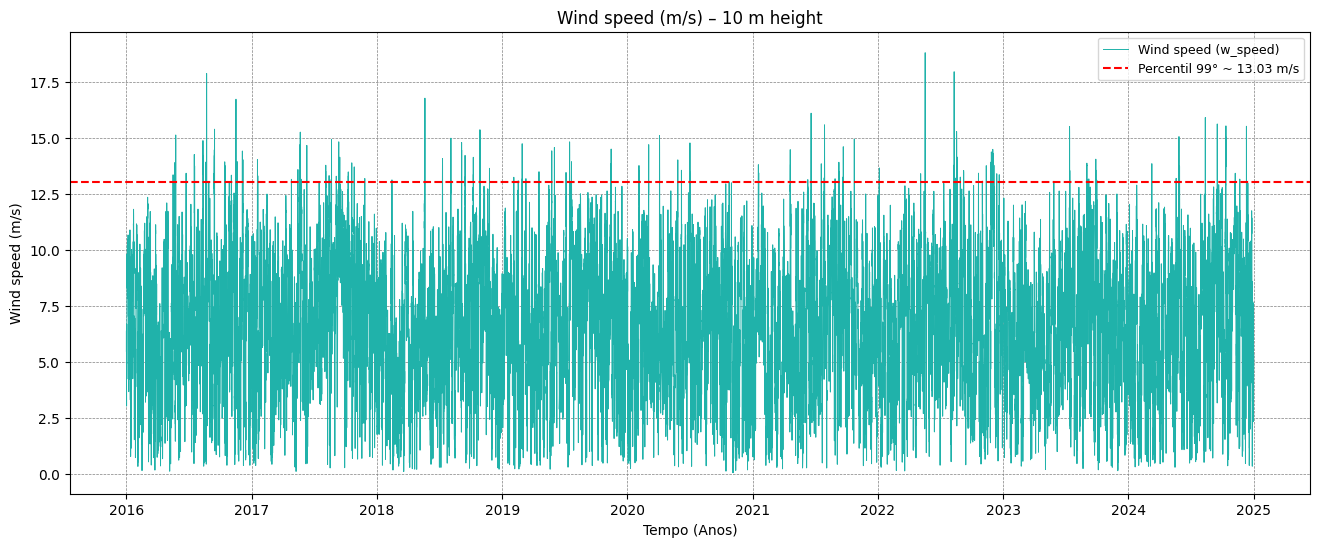

In [37]:
# plot wind speed time series
plt.figure(figsize=(16, 6))
plt.plot(wind_df.index, wind_df['wind_speed'], label='Wind speed (w_speed)', color='lightseagreen', linewidth=0.7)
# plt.axhline(y=wind_q95, color='blue', linestyle='--', label=f'Percentil 95°~ {wind_q95:.2f} m/s')
plt.axhline(y=wind_q99, color='red', linestyle='--', label=f'Percentil 99° ~ {wind_q99:.2f} m/s')
plt.title('Wind speed (m/s) – 10 m height')
plt.xlabel('Tempo (Anos)')
plt.ylabel('Wind speed (m/s)')
plt.grid(
    which='both', linestyle='--', linewidth=0.5, color='gray'
)
plt.legend(
    fontsize = 9
)
plt.show()


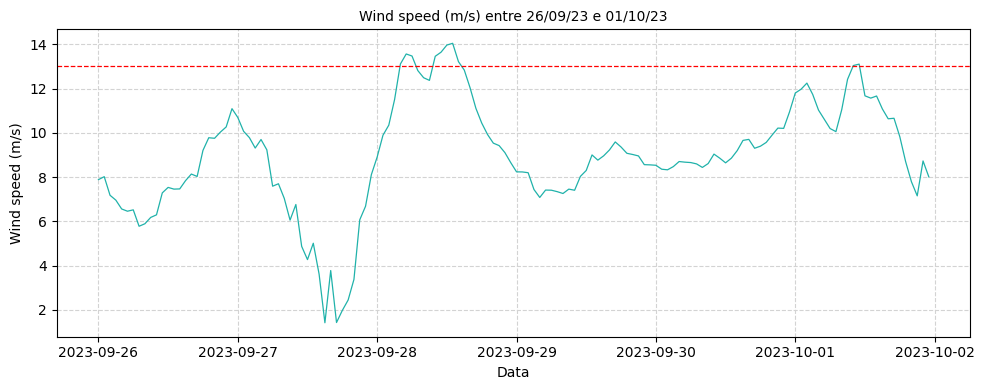

In [38]:
# Plotar série temporal de speed do vento entre 26/09/2023 e 01/09/2023
start_date = '2023-09-26'
end_date = '2023-10-01'

wind_period = wind_df.loc[start_date:end_date]

plt.figure(figsize=(10, 4))
plt.plot(wind_period.index, wind_period['wind_speed'], color='lightseagreen', linewidth=0.9)
plt.axhline(y=wind_q99, color='red', linestyle='--', label=f'Percentil 99° ~ {wind_q99:.2f} m/s', linewidth=0.9)
plt.title('Wind speed (m/s) entre 26/09/23 e 01/10/23', fontsize=10)
plt.xlabel('Data', fontsize=10)
plt.ylabel('Wind speed (m/s)', fontsize=10)
plt.grid(linestyle='--', color='lightgray')
plt.tight_layout()
plt.show()

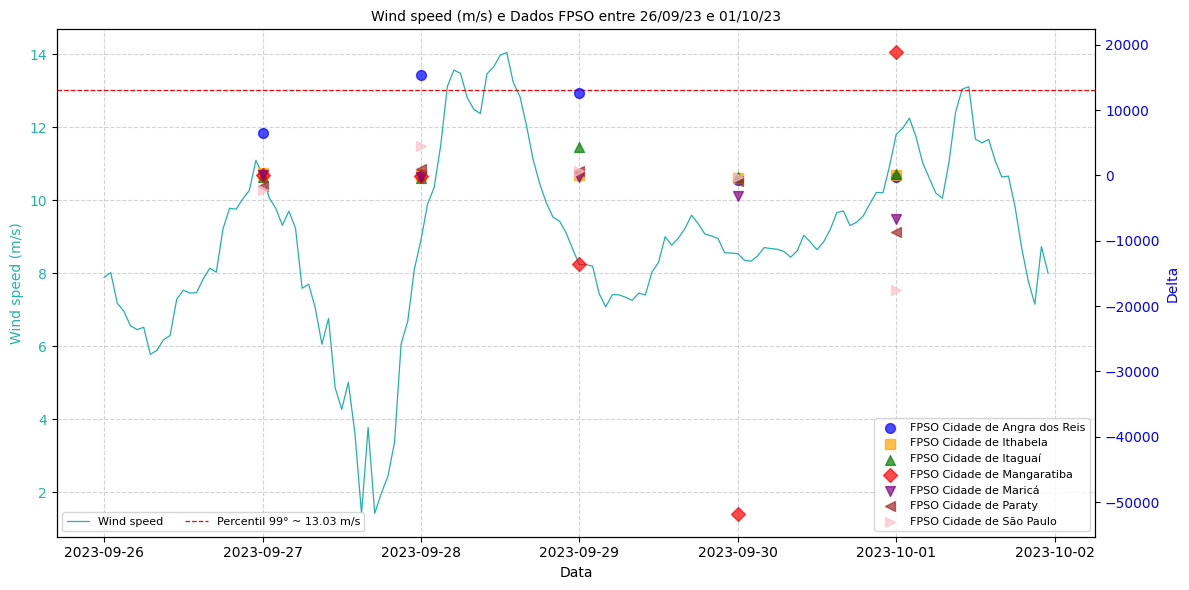

In [39]:
# Plotar série temporal de speed do vento entre 26/09/2023 e 01/10/2023
start_date = '2023-09-26'
end_date = '2023-10-01'

wind_period = wind_df.loc[start_date:end_date]

# Create DataFrame from your tabulated data
data = {
    'date': ['2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
             '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
             '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
             '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
             '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
             '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
             '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01'],
    'delta': [6441.50, 15297.08, 12548.85, -659.72, -311.32, -1037.06,
              330.83, 62.34, 121.61, -382.34, 80.01, -507.78,
              -209.88, -397.84, 4312.61, -170.36, 145.53, -125.10,
              53.49, -149.21, -13548.85, -51758.05, 18819.16, -20892.43,
              121.92, -285.45, -201.13, -3123.04, -6679.07, 9996.16,
              -1673.75, 1005.46, 685.24, -866.01, -8591.87, 1311.10,
              -2302.36, 4501.57, 657.31, -261.28, -17513.33, -19269.07],
    'FPSO': ['FPSO Cidade de Angra dos Reis', 'FPSO Cidade de Angra dos Reis', 'FPSO Cidade de Angra dos Reis', 'FPSO Cidade de Angra dos Reis', 'FPSO Cidade de Angra dos Reis', 'FPSO Cidade de Angra dos Reis',
             'FPSO Cidade de Ithabela', 'FPSO Cidade de Ithabela', 'FPSO Cidade de Ithabela', 'FPSO Cidade de Ithabela', 'FPSO Cidade de Ithabela', 'FPSO Cidade de Ithabela',
             'FPSO Cidade de Itaguaí', 'FPSO Cidade de Itaguaí', 'FPSO Cidade de Itaguaí', 'FPSO Cidade de Itaguaí', 'FPSO Cidade de Itaguaí', 'FPSO Cidade de Itaguaí',
             'FPSO Cidade de Mangaratiba', 'FPSO Cidade de Mangaratiba', 'FPSO Cidade de Mangaratiba', 'FPSO Cidade de Mangaratiba', 'FPSO Cidade de Mangaratiba', 'FPSO Cidade de Mangaratiba',
             'FPSO Cidade de Maricá', 'FPSO Cidade de Maricá', 'FPSO Cidade de Maricá', 'FPSO Cidade de Maricá', 'FPSO Cidade de Maricá', 'FPSO Cidade de Maricá',
             'FPSO Cidade de Paraty', 'FPSO Cidade de Paraty', 'FPSO Cidade de Paraty', 'FPSO Cidade de Paraty', 'FPSO Cidade de Paraty', 'FPSO Cidade de Paraty',
             'FPSO Cidade de São Paulo', 'FPSO Cidade de São Paulo', 'FPSO Cidade de São Paulo', 'FPSO Cidade de São Paulo', 'FPSO Cidade de São Paulo', 'FPSO Cidade de São Paulo']
}

fpsodf = pd.DataFrame(data)
fpsodf['date'] = pd.to_datetime(fpsodf['date'])

# Truncate dates to end of day
fpsodf['date'] = fpsodf['date'] + pd.Timedelta(hours=23, minutes=59, seconds=59)

# Filter data for the date range
fpsodf = fpsodf[(fpsodf['date'] >= start_date) & (fpsodf['date'] <= end_date)]

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# First y-axis (wind speed)
color1 = 'lightseagreen'
ax1.plot(wind_period.index, wind_period['wind_speed'], color=color1, linewidth=0.9, label='Wind speed')
ax1.axhline(y=wind_q99, color='red', linestyle='--', label=f'Percentil 99° ~ {wind_q99:.2f} m/s', linewidth=0.9)
ax1.set_xlabel('Data', fontsize=10)
ax1.set_ylabel('Wind speed (m/s)', fontsize=10, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(linestyle='--', color='lightgray')

# Second y-axis (delta values)
ax2 = ax1.twinx()
color2 = 'blue'

# Plot each FPSO with different markers/colors
fpsos = fpsodf['FPSO'].unique()
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
markers = ['o', 's', '^', 'D', 'v', '<', '>']

for i, fpsos in enumerate(fpsos):
    fpsos_data = fpsodf[fpsodf['FPSO'] == fpsos]
    ax2.scatter(fpsos_data['date'], fpsos_data['delta'], 
               color=colors[i % len(colors)], marker=markers[i % len(markers)], 
               label=fpsos, alpha=0.7, s=50)

ax2.set_ylabel('Delta', fontsize=10, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Wind speed (m/s) e Dados FPSO entre 26/09/23 e 01/10/23', fontsize=10)

# Add legends
ax1.legend(loc='lower left', ncol=2, fontsize=8)
ax2.legend(loc='lower right', ncol=1, fontsize=8)

fig.tight_layout()
plt.show()

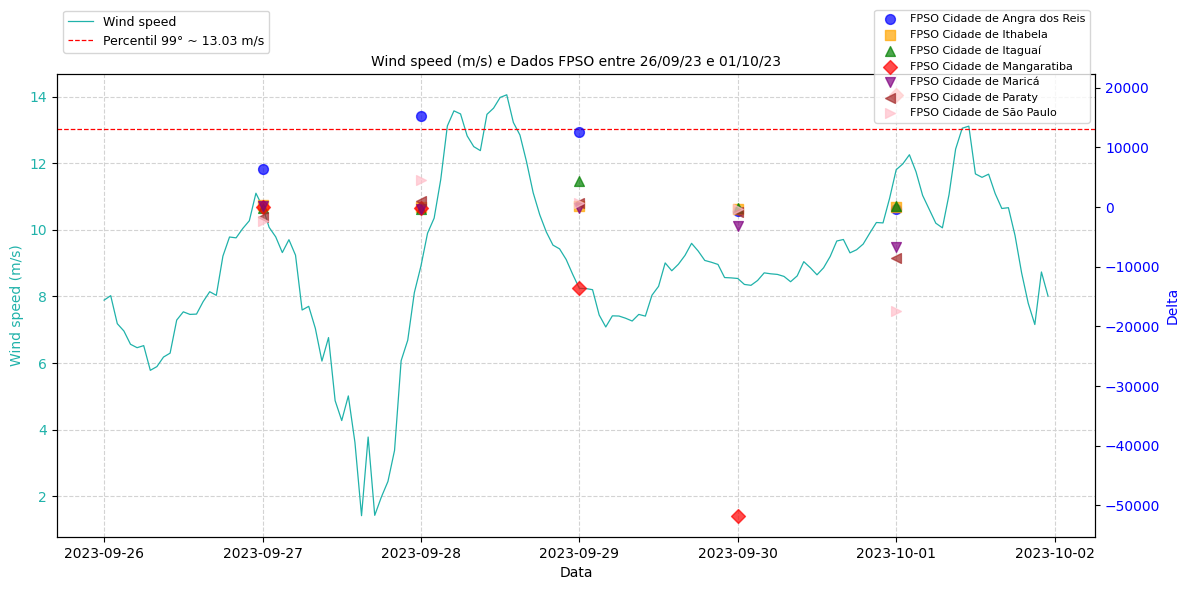

In [40]:
# Plotar série temporal de speed do vento entre 26/09/2023 e 01/10/2023
start_date = '2023-09-26'
end_date = '2023-10-01'

wind_period = wind_df.loc[start_date:end_date]

fpsodf = pd.DataFrame(data)
fpsodf['date'] = pd.to_datetime(fpsodf['date'])
fpsodf['date'] = fpsodf['date'] + pd.Timedelta(hours=23, minutes=59, seconds=59)
fpsodf = fpsodf[(fpsodf['date'] >= start_date) & (fpsodf['date'] <= end_date)]

fig, ax1 = plt.subplots(figsize=(12, 6))

color1 = 'lightseagreen'
ax1.plot(wind_period.index, wind_period['wind_speed'], color=color1, linewidth=0.9, label='Wind speed')
ax1.axhline(y=wind_q99, color='red', linestyle='--', label=f'Percentil 99° ~ {wind_q99:.2f} m/s', linewidth=0.9)
ax1.set_xlabel('Data', fontsize=10)
ax1.set_ylabel('Wind speed (m/s)', fontsize=10, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(linestyle='--', color='lightgray')

ax2 = ax1.twinx()
color2 = 'blue'

fpsos = fpsodf['FPSO'].unique()
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
markers = ['o', 's', '^', 'D', 'v', '<', '>']

for i, fpsos_name in enumerate(fpsos):
    fpsos_data = fpsodf[fpsodf['FPSO'] == fpsos_name]
    ax2.scatter(fpsos_data['date'], fpsos_data['delta'], 
               color=colors[i % len(colors)], marker=markers[i % len(markers)], 
               label=fpsos_name, alpha=0.7, s=50)

ax2.set_ylabel('Delta', fontsize=10, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Wind speed (m/s) e Dados FPSO entre 26/09/23 e 01/10/23', fontsize=10)

# Add legends outside the plot
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1.15), fontsize=9)
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.15), fontsize=8)

fig.tight_layout()
plt.show()

In [41]:
len(wind_df['wind_speed'])

78912

In [42]:
# data na qual foi registrado o maior valor diário de speed do vento
wind_df['wind_speed'].idxmax()
wind_df['wind_speed'].idxmin()

Timestamp('2020-11-05 09:00:00')

In [43]:
# quantificar picos acima do quartil 99 para a variavel de speed do vento
print(f'o valor do percentil 99 é {wind_q99}')
print(f'a variável de speed do vento ultrapassou {len(wind_df[wind_df['wind_speed']>wind_q99])} vezes')
print(f'o valor máximo de speed do vento foi de {wind_df['wind_speed'].max()}')
print(f'o valor mínimo de speed do vento foi de {wind_df['wind_speed'].min()}')
print(f' isso representa {len(wind_df[wind_df['wind_speed']>wind_q99])/len(wind_df)*100} % dos dias')

o valor do percentil 99 é 13.032486171722411
a variável de speed do vento ultrapassou 790 vezes
o valor máximo de speed do vento foi de 18.809511184692383
o valor mínimo de speed do vento foi de 0.04702938348054886
 isso representa 1.0011151662611517 % dos dias


In [44]:
print(f'{len(wind_df[wind_df['wind_speed']>wind_q99])}')

790


In [45]:
wind_df['wind_direction'].describe()

count    78912.000000
mean       113.997566
std         88.859596
min          0.013977
25%         42.768692
50%         86.569443
75%        166.127132
max        359.999603
Name: wind_direction, dtype: float64

(array([2402., 4723., 7955., 7841., 6472., 5213., 4032., 3703., 3366.,
        3113., 2980., 2765., 2568., 2393., 2193., 1990., 1860., 1723.,
        1678., 1460., 1204.,  882.,  731.,  657.,  597.,  609.,  644.,
         722.,  963., 1473.]),
 array([1.39770508e-02, 1.20134983e+01, 2.40130196e+01, 3.60125427e+01,
        4.80120621e+01, 6.00115814e+01, 7.20111084e+01, 8.40106277e+01,
        9.60101471e+01, 1.08009666e+02, 1.20009186e+02, 1.32008713e+02,
        1.44008240e+02, 1.56007751e+02, 1.68007278e+02, 1.80006790e+02,
        1.92006317e+02, 2.04005844e+02, 2.16005356e+02, 2.28004883e+02,
        2.40004395e+02, 2.52003922e+02, 2.64003448e+02, 2.76002960e+02,
        2.88002502e+02, 3.00002014e+02, 3.12001526e+02, 3.24001038e+02,
        3.36000580e+02, 3.48000092e+02, 3.59999603e+02]),
 <BarContainer object of 30 artists>)

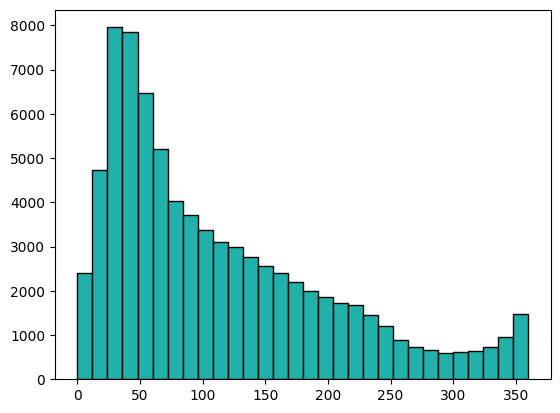

In [46]:
plt.hist(wind_df['wind_direction'], bins=30, color='lightseagreen', edgecolor='black')

In [47]:
wind_df['wind_speed'].describe()

count    78912.000000
mean         6.749501
std          2.767858
min          0.047029
25%          4.714171
50%          6.736311
75%          8.699273
max         18.809511
Name: wind_speed, dtype: float64

(array([5.9900e+03, 2.0203e+04, 2.7181e+04, 1.9493e+04, 5.5450e+03,
        4.8200e+02, 1.8000e+01]),
 array([ 0.04702938,  2.72738409,  5.40773869,  8.0880928 , 10.76844788,
        13.44880295, 16.12915611, 18.80951118]),
 <BarContainer object of 7 artists>)

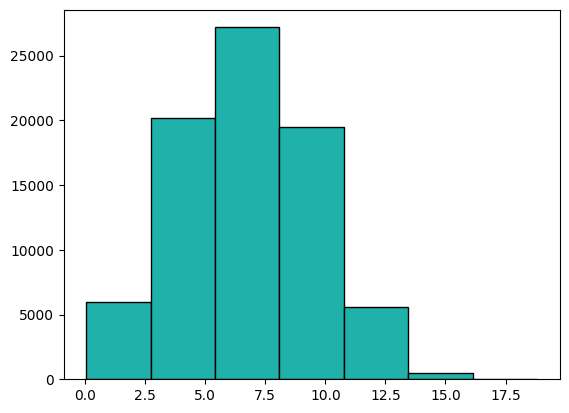

In [48]:
plt.hist(wind_df['wind_speed'], bins=7, color='lightseagreen', edgecolor='black')

NameError: name 'wind_ds_point' is not defined

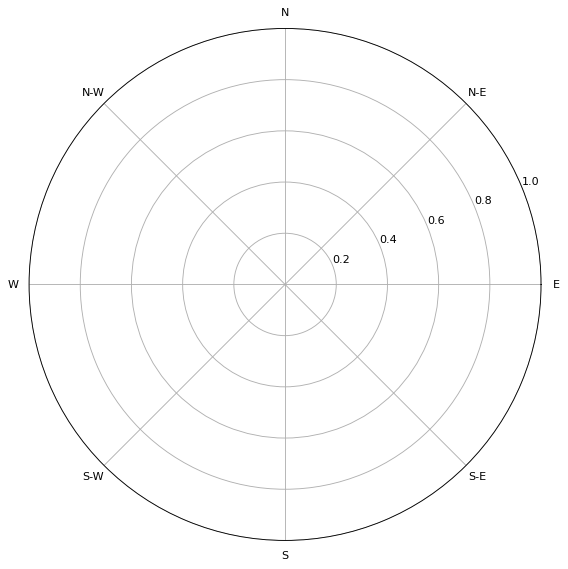

In [49]:
# Wind rose plot for wind direction and speed
ax = windrose.WindroseAxes.from_ax(figsize=(8, 8))
# ax.set_theta_zero_location('N')
# ax.set_theta_direction(-1)

# Define bins for wind speed
wind_bins = [0, 2, 4, 6, 8, 10, 12, 13]
wind_labels = ['0-2.0', '2.0-4.0', '4.0-6.0', '6.0-8.0', '8.0-10.0', '10.0-12.0', '12.0-13.0', '>13.0']

ax.bar( 
    (wind_ds_point['wind_direction']),  # Adjust direction to match meteorological convention
    wind_df['wind_speed'],
    bins=15,
    nsector=8,
    normed=True,
    opening=0.8,
    edgecolor='white',
    linewidth=0.5,
    cmap=plt.cm.RdYlBu_r
)

legend = ax.set_legend(title='Wind speed (m/s)',
              loc='upper right', 
              bbox_to_anchor=(1.48, 1), 
            #   labels=wind_labels,
              fontsize=12)
# Ajustar título
plt.setp(legend.get_title(), fontsize=16)
# Ajustar labels
for text in legend.get_texts():
    text.set_fontsize(16)

ax.set_title('Wind speed and direction (2016–2024)', pad=20, fontsize=16)

ax.set_rlabel_position(120)
ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%2.0f'))

plt.show()

In [ ]:
wind_q99

np.float64(13.032486171722411)

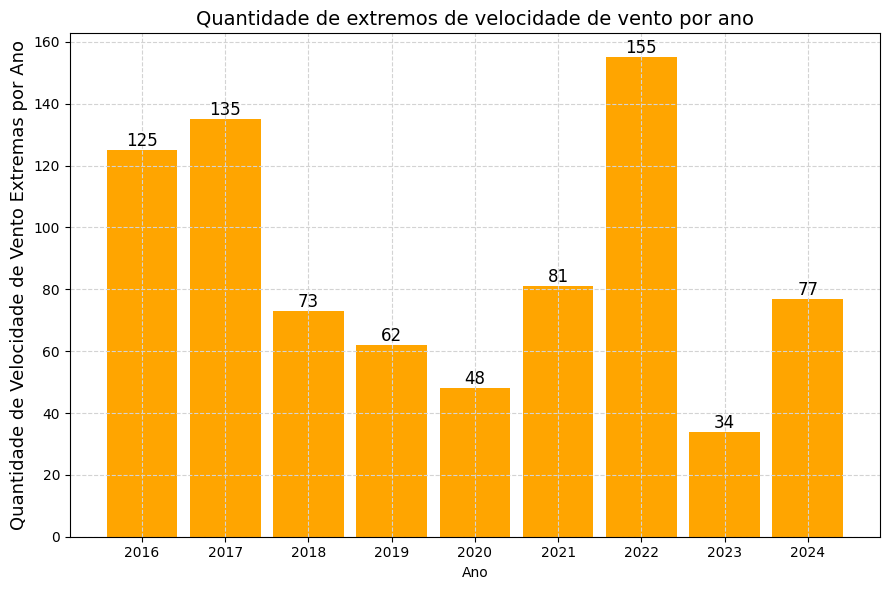

In [ ]:
extreme_wind = wind_df[wind_df['wind_speed'] > wind_q99]
# É melhor agrupar por ano para contar a quantidade de extremes em cada ano
extreme_counts_by_year = extreme_wind.groupby(extreme_wind.index.year).count()

plt.figure(figsize=(9, 6))
bars = plt.bar(extreme_counts_by_year.index, extreme_counts_by_year['wind_speed'].values, color='orange', width=0.85)

# Adicionar os labels numéricos acima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=12)

plt.title(f'Quantidade de extremes de speed de vento por ano', fontsize=14)
plt.xlabel('Ano', fontsize=10)
plt.ylabel('Number of extreme wind-speed events per year', fontsize=13)
plt.grid(
    linestyle = "--",
    color = "lightgray"
)
plt.xticks(extreme_counts_by_year.index) # Garante que todos os anos com dados sejam mostrados no eixo X
plt.tight_layout() # Ajusta o layout para evitar cortes
plt.show()


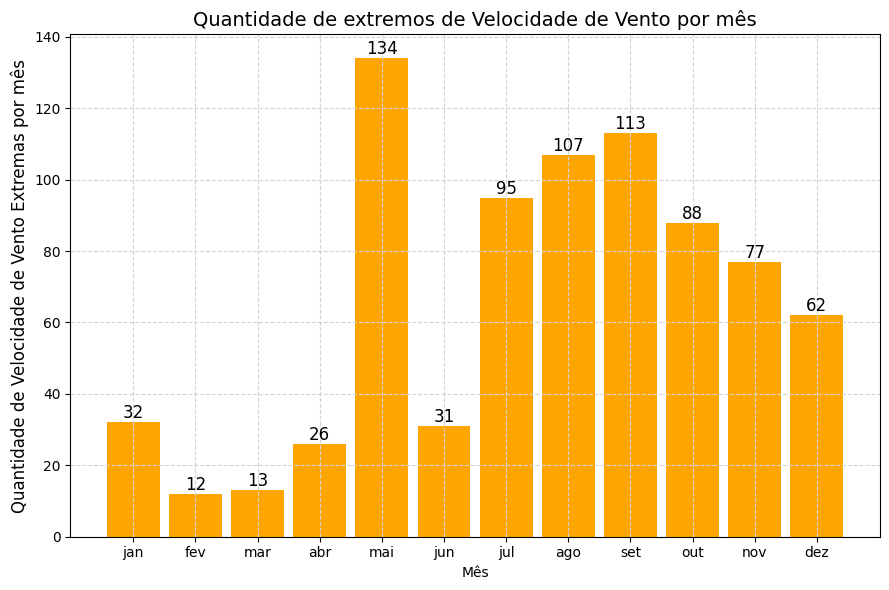

In [ ]:
month_label = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez']
extreme_values_per_month(wind_df,'wind_speed',wind_q99, "Velocidade de Vento")

In [ ]:
# calcular direction média de vento por estação
summer_months = [12, 1, 2]
w_summer = wind_df[wind_df.index.month.isin(summer_months)]

autumn_months = [3, 4, 5]
w_autumn = wind_df[wind_df.index.month.isin(autumn_months)]

winter_months = [6, 7, 8]
w_winter = wind_df[wind_df.index.month.isin(winter_months)]

spring_months = [9, 10, 11]
w_spring = wind_df[wind_df.index.month.isin(spring_months)]

In [ ]:
wind_df.columns

Index(['wind_u', 'wind_v', 'latitude', 'longitude', 'wind_speed',
       'wind_direction_rad', 'wind_direction_deg', 'wind_direction'],
      dtype='object')

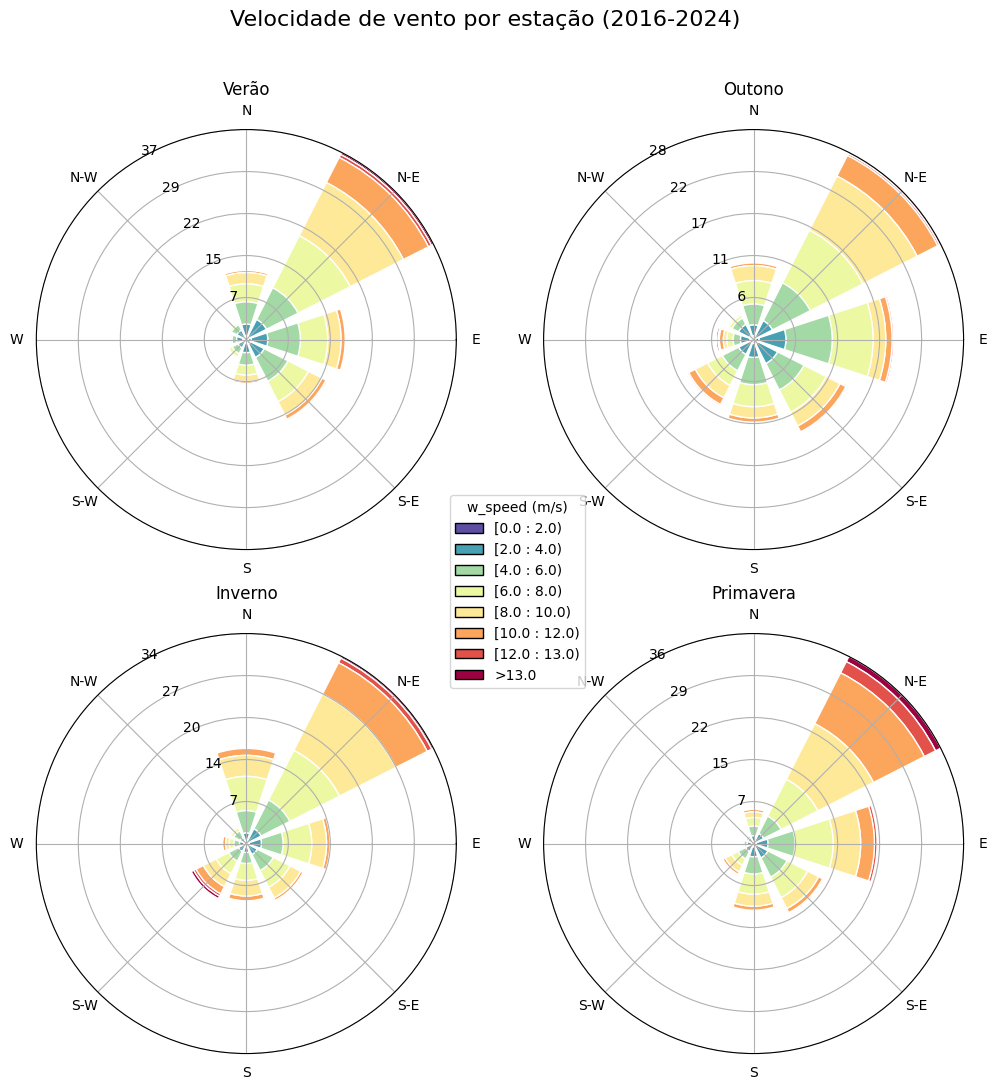

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), subplot_kw=dict(projection='windrose'))

seasons = {'Verão': w_summer, 'Outono': w_autumn, 'Inverno': w_winter, 'Primavera': w_spring}

# Define bins for wind speed
wind_bins = [0, 2, 4, 6, 8, 10, 12, 13]
wind_labels = ['0-2.0', '2.0-4.0', '4.0-6.0', '6.0-8.0', '8.0-10.0', '10.0-12.0', '12.0-13.0', '>13.0']

i = 0
for season, data in seasons.items():
    ax = axes.flatten()[i]
    ax.bar(data['wind_direction'], data['wind_speed'],
           bins = wind_bins,
           normed=True, 
           opening=0.8,
           nsector=8,
           edgecolor='white', 
           cmap=cm.Spectral_r)
    ax.set_title(season)
    i += 1
    ax.set_rlabel_position(120)
    ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%2.0f'))
# Add a single legend to the last subplot
ax.legend(title="w_speed (m/s)", loc='center left', bbox_to_anchor=(-0.24, 1.1))

fig.suptitle('Velocidade de vento por estação (2016-2024)', fontsize=16)
# plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust layout to make room for the title
plt.show()

# CYCLONE PERIODS

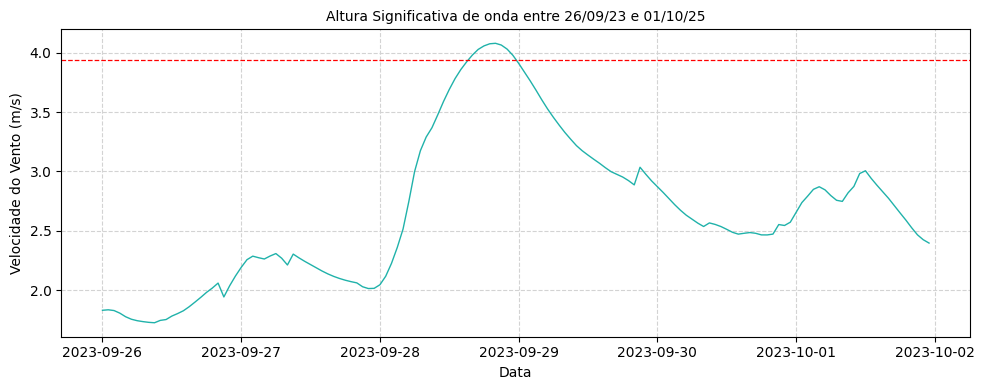

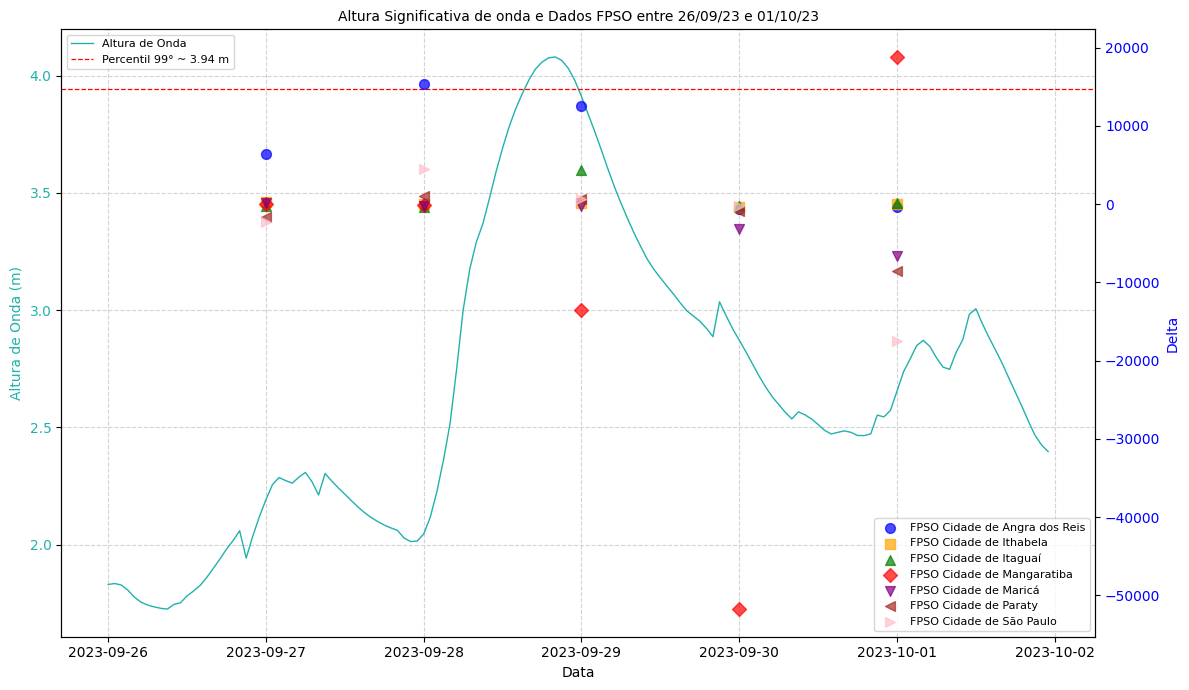

In [ ]:
# Plotar série temporal de speed do vento entre 26/09/2023 e 01/09/2023
start_date = '2023-09-26'
end_date = '2023-10-01'

wave_period = Hs.loc[start_date:end_date]

plt.figure(figsize=(10, 4))
plt.plot(wave_period.index, wave_period['wave_height'], color='lightseagreen', linewidth=1)
plt.axhline(y=q99_Hs, color='red', linestyle='--', label=f'Percentil 99° ~ {q99_Hs:.2f} m', linewidth=0.9)
plt.title('Significant wave height between 26/Sep/2023 and 01/Oct/2023', fontsize=10)
plt.xlabel('Data', fontsize=10)
plt.ylabel('Wind speed (m/s)', fontsize=10)
plt.grid(linestyle='--', color='lightgray')
plt.tight_layout()
plt.show()

start_date = '2023-09-26'
end_date = '2023-10-01'

wave_period = Hs.loc[start_date:end_date]

# Create DataFrame from your tabulated data
data = {
    'date': ['2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
             '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
             '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
             '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
             '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
             '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01',
             '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01'],
    'delta': [6441.50, 15297.08, 12548.85, -659.72, -311.32, -1037.06,
              330.83, 62.34, 121.61, -382.34, 80.01, -507.78,
              -209.88, -397.84, 4312.61, -170.36, 145.53, -125.10,
              53.49, -149.21, -13548.85, -51758.05, 18819.16, -20892.43,
              121.92, -285.45, -201.13, -3123.04, -6679.07, 9996.16,
              -1673.75, 1005.46, 685.24, -866.01, -8591.87, 1311.10,
              -2302.36, 4501.57, 657.31, -261.28, -17513.33, -19269.07],
    'FPSO': ['FPSO Cidade de Angra dos Reis', 'FPSO Cidade de Angra dos Reis', 'FPSO Cidade de Angra dos Reis', 'FPSO Cidade de Angra dos Reis', 'FPSO Cidade de Angra dos Reis', 'FPSO Cidade de Angra dos Reis',
             'FPSO Cidade de Ithabela', 'FPSO Cidade de Ithabela', 'FPSO Cidade de Ithabela', 'FPSO Cidade de Ithabela', 'FPSO Cidade de Ithabela', 'FPSO Cidade de Ithabela',
             'FPSO Cidade de Itaguaí', 'FPSO Cidade de Itaguaí', 'FPSO Cidade de Itaguaí', 'FPSO Cidade de Itaguaí', 'FPSO Cidade de Itaguaí', 'FPSO Cidade de Itaguaí',
             'FPSO Cidade de Mangaratiba', 'FPSO Cidade de Mangaratiba', 'FPSO Cidade de Mangaratiba', 'FPSO Cidade de Mangaratiba', 'FPSO Cidade de Mangaratiba', 'FPSO Cidade de Mangaratiba',
             'FPSO Cidade de Maricá', 'FPSO Cidade de Maricá', 'FPSO Cidade de Maricá', 'FPSO Cidade de Maricá', 'FPSO Cidade de Maricá', 'FPSO Cidade de Maricá',
             'FPSO Cidade de Paraty', 'FPSO Cidade de Paraty', 'FPSO Cidade de Paraty', 'FPSO Cidade de Paraty', 'FPSO Cidade de Paraty', 'FPSO Cidade de Paraty',
             'FPSO Cidade de São Paulo', 'FPSO Cidade de São Paulo', 'FPSO Cidade de São Paulo', 'FPSO Cidade de São Paulo', 'FPSO Cidade de São Paulo', 'FPSO Cidade de São Paulo']
}

fpsodf = pd.DataFrame(data)
fpsodf['date'] = pd.to_datetime(fpsodf['date'])

# Truncate dates to end of day
fpsodf['date'] = fpsodf['date'] + pd.Timedelta(hours=23, minutes=59, seconds=59)

# Filter data for the date range
fpsodf = fpsodf[(fpsodf['date'] >= start_date) & (fpsodf['date'] <= end_date)]

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 7))

# First y-axis (wave height)
color1 = 'lightseagreen'
ax1.plot(wave_period.index, wave_period['wave_height'], color=color1, linewidth=1, label='Wave height')
ax1.axhline(y=q99_Hs, color='red', linestyle='--', label=f'Percentil 99° ~ {q99_Hs:.2f} m', linewidth=0.9)
ax1.set_xlabel('Data', fontsize=10)
ax1.set_ylabel('Wave height (m)', fontsize=10, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(linestyle='--', color='lightgray')

# Second y-axis (delta values)
ax2 = ax1.twinx()
color2 = 'blue'

# Plot each FPSO with different markers/colors
fpsos = fpsodf['FPSO'].unique()
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
markers = ['o', 's', '^', 'D', 'v', '<', '>']

for i, fpsos in enumerate(fpsos):
    fpsos_data = fpsodf[fpsodf['FPSO'] == fpsos]
    ax2.scatter(fpsos_data['date'], fpsos_data['delta'], 
               color=colors[i % len(colors)], marker=markers[i % len(markers)], 
               label=fpsos, alpha=0.7, s=50)

ax2.set_ylabel('Delta', fontsize=10, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Significant wave height and FPSO data between 26/Sep/2023 and 01/Oct/2023', fontsize=10)

# Add legends
ax1.legend(loc='upper left', ncol=1, fontsize=8)
ax2.legend(loc='lower right', ncol=1, fontsize=8)

fig.tight_layout()
plt.show()

In [50]:
# importar dados de datas de ciclones

cyclone_data = pd.read_csv("D:/SARC_LISA_2024/01_dados_brutos/PETROBRAS/producao_paltaformass_bacia_santos/planilhas_IC_produção_ANP/datas_ciclones_SARC_2016_2024_modificado.csv")

cyclone_data['inicio'] = pd.to_datetime(cyclone_data['inicio'], format='%m/%d/%Y')
cyclone_data['fim'] = pd.to_datetime(cyclone_data['fim'], format='%m/%d/%Y')

#  criando um dicionário para armazenar os dados filtrados de cada ciclone

dados_ciclones = {}

for idx, row in cyclone_data.iterrows():
    nome_ciclone = row['tipo']
    data_inicio = row['inicio']
    data_fim = row['fim']

    # Verifica se a data_fim não é NaT (caso do CET_02)
    if pd.isna(data_fim):
        print(f"Ciclone {nome_ciclone} não tem data final definida. Pulando...")
        continue

    try:
        # Filtra os dados entre as datas de início e fim
        dados_filtrados = current_15m_df.loc[data_inicio:data_fim]

        # Armazena no dicionário
        dados_ciclones[nome_ciclone] = dados_filtrados

        print(f"Dados extraídos para {nome_ciclone} ({data_inicio} a {data_fim}) - {len(dados_filtrados)} registros")
    except Exception as e:
        print(f"Erro ao processar {nome_ciclone}: {str(e)}")

# Agora você tem um dicionário onde cada chave é o nome do ciclone
# e o valor é o dataframe filtrado para o período correspondente
    

Dados extraídos para subtropical (2016-01-05 00:00:00 a 2016-01-06 00:00:00) - 1 registros
Dados extraídos para subtropical (2016-11-15 00:00:00 a 2016-11-16 00:00:00) - 1 registros
Dados extraídos para subtropical (2016-12-04 00:00:00 a 2016-12-06 00:00:00) - 2 registros
Dados extraídos para subtropical (2017-12-09 00:00:00 a 2017-12-10 00:00:00) - 1 registros
Dados extraídos para subtropical (2019-03-23 00:00:00 a 2019-03-27 00:00:00) - 4 registros
Dados extraídos para subtropical (2019-05-19 00:00:00 a 2019-05-21 00:00:00) - 2 registros
Dados extraídos para subtropical (2020-01-23 00:00:00 a 2020-01-24 00:00:00) - 1 registros
Dados extraídos para subtropical (2020-10-25 00:00:00 a 2020-10-27 00:00:00) - 2 registros
Dados extraídos para subtropical (2020-12-27 00:00:00 a 2020-12-30 00:00:00) - 3 registros
Dados extraídos para subtropical (2021-02-14 00:00:00 a 2021-02-16 00:00:00) - 3 registros
Dados extraídos para subtropical (2021-04-19 00:00:00 a 2021-04-24 00:00:00) - 6 registros

In [53]:
current_15m_df

,Unnamed: 0,current_speed,current_direction
time,,,
2016-01-01 12:00:00,0,0.189239,90.924045
2016-01-02 12:00:00,1,0.195816,110.242500
2016-01-03 12:00:00,2,0.211780,131.962664
2016-01-04 12:00:00,3,0.265949,139.840860
2016-01-05 12:00:00,4,0.294198,150.137166
...,...,...,...
2024-12-27 00:00:00,3283,0.213128,262.264395
2024-12-28 00:00:00,3284,0.300935,260.308419
2024-12-29 00:00:00,3285,0.309025,261.709854


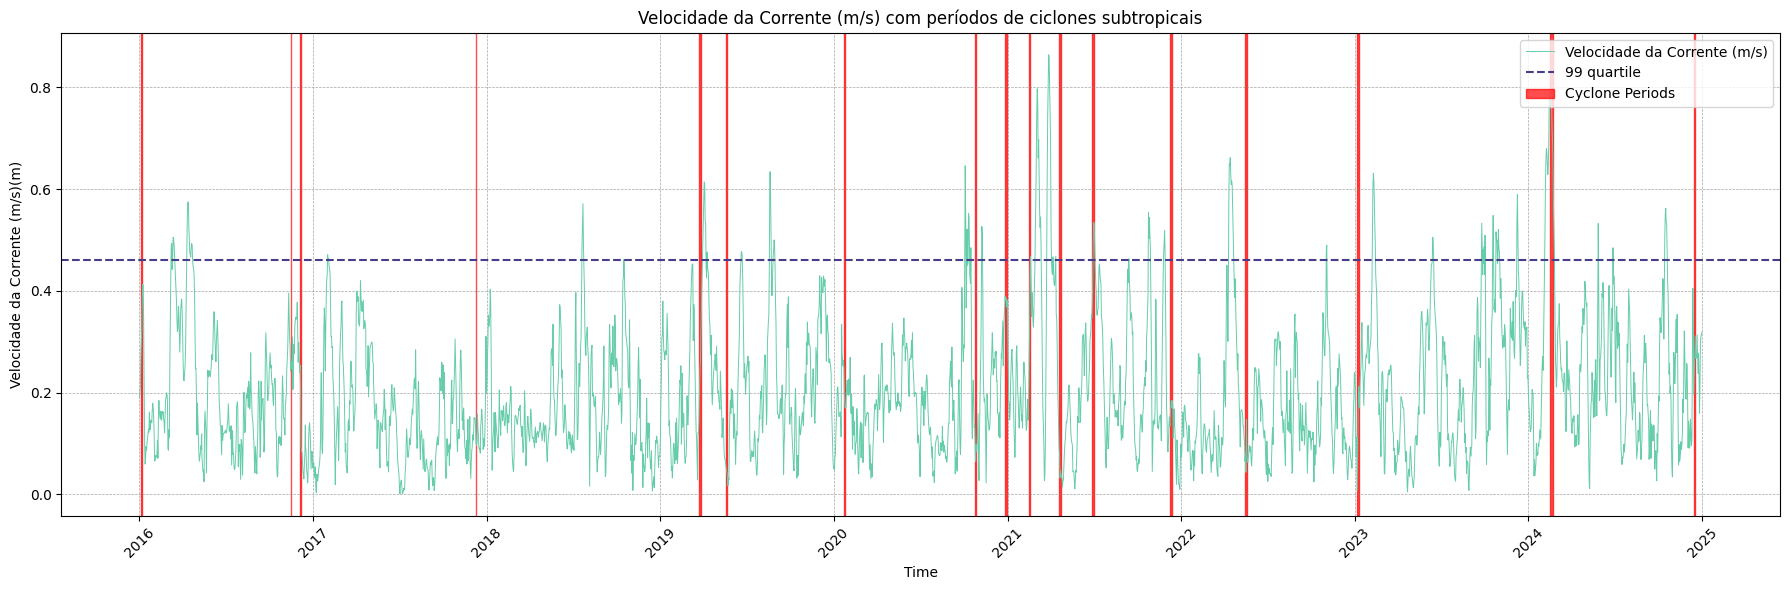

In [54]:
variable = 'current_speed'
variable_name = 'Velocidade da Corrente (m/s)'
dataframe = current_15m_df


plt.figure(figsize=(18, 6))

# Plotar a série temporal de altura de ondas
plt.plot(dataframe.index, dataframe[f'{variable}'], label=f"{variable_name}", color="mediumaquamarine", linewidth=0.7)

plt.axhline(y=q95, color='darkslateblue', linestyle='--',
            label=f"95th Percentile ({q95:.2f} m/s)")

# Adicionar faixas verticais para os períodos de ciclones
for _, row in cyclone_data.iterrows():
    plt.axvspan(row["inicio"], row["fim"], color="red", alpha=0.7, label=row["nome"] if row["nome"] == cyclone_data.iloc[0]["nome"] else None)

# Configurar o gráfico
plt.xlabel("Time")
plt.ylabel(f"{variable_name}(m)")
plt.title(f"{variable_name} com períodos de ciclones subtropicais")
plt.xticks(rotation=45)
plt.legend([f"{variable_name}", "99 quartile", "Cyclone Periods"], loc="upper right")
plt.tight_layout()
plt.grid(linestyle="--", linewidth=0.5, alpha=0.7, color="gray")

plt.show()
#plt.savefig("wind_speed_with_cyclones.png", dpi=300, bbox_inches='tight')

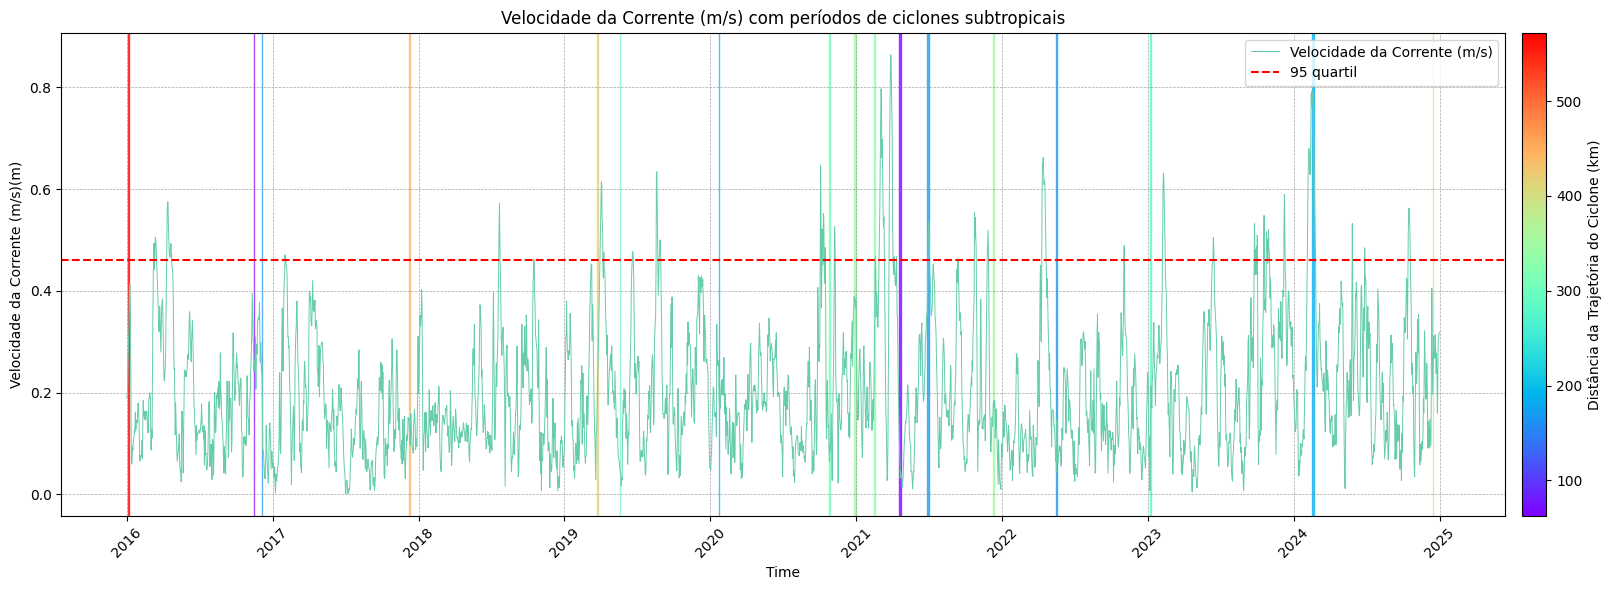

In [55]:
# Normalizar os valores de distancia_trajetoria para o colormap
norm = mcolors.Normalize(vmin=cyclone_data["distancia_trajetoria"].min(), vmax=cyclone_data["distancia_trajetoria"].max())
cmap = plt.cm.rainbow  # Escolha um colormap adequado

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(dataframe.index, dataframe[variable], label=variable_name, color="mediumaquamarine", linewidth=0.7)
ax.axhline(y=q95, color='red', linestyle='--', label=f"95th Percentile ({q95:.2f} m/s)")

# Adicionar faixas verticais coloridas conforme distancia_trajetoria
for _, row in cyclone_data.iterrows():
    color = cmap(norm(row["distancia_trajetoria"]))
    ax.axvspan(row["inicio"], row["fim"], color=color, alpha=0.7, label=None)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # necessário para a colorbar
cbar = plt.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label('Distância da Trajetória do Ciclone (km)')

ax.set_xlabel("Time")
ax.set_ylabel(f"{variable_name}(m)")
ax.set_title(f"{variable_name} com períodos de ciclones subtropicais")
ax.tick_params(axis='x', rotation=45)
ax.legend([f"{variable_name}", "95 quartil"], loc="upper right")
plt.tight_layout()
ax.grid(linestyle="--", linewidth=0.5, alpha=0.7, color="gray")
plt.show()

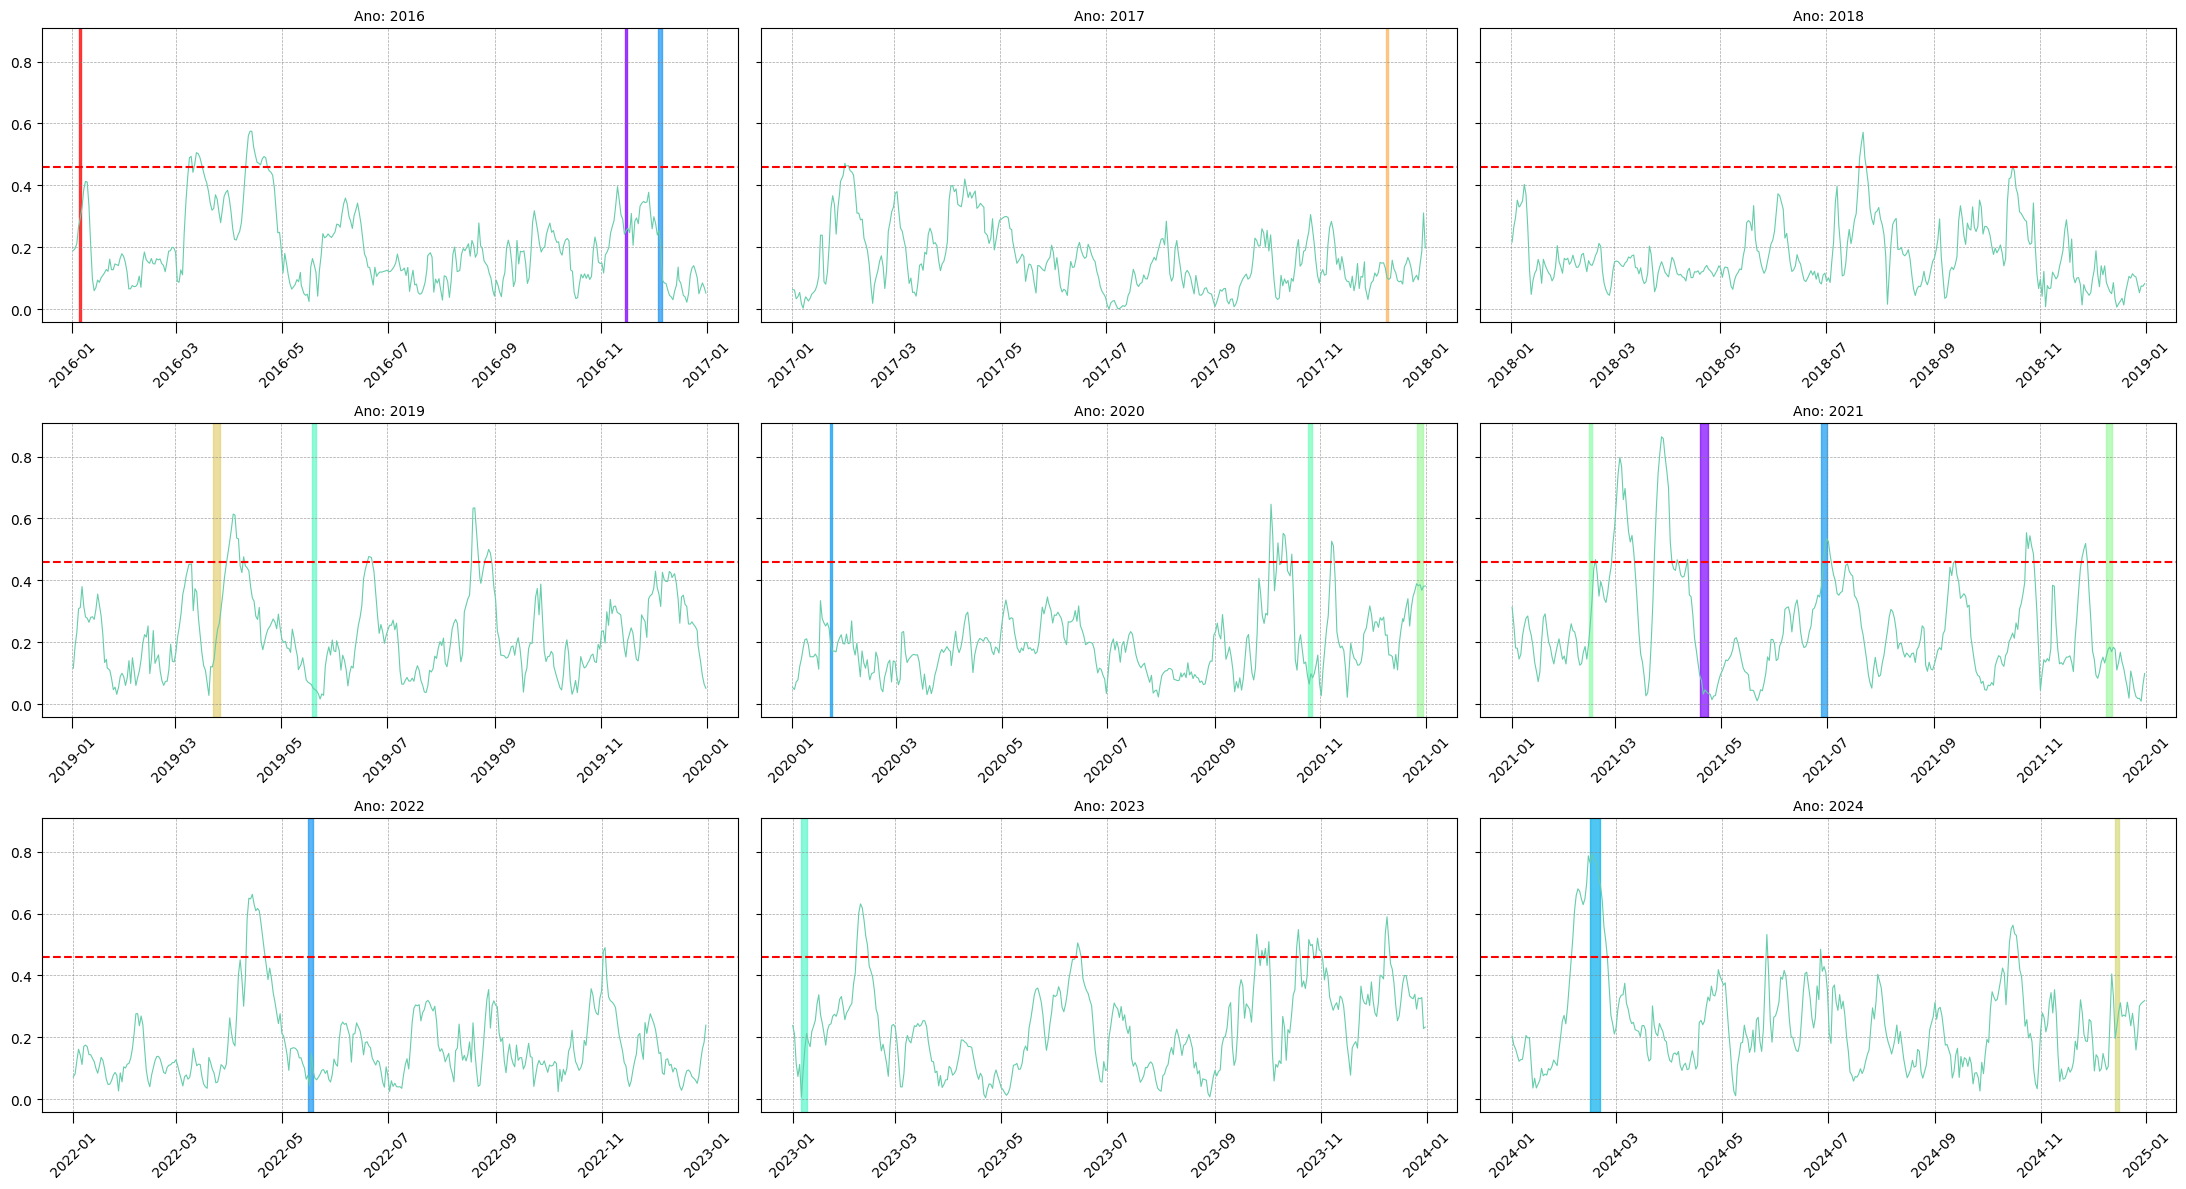

In [56]:
# Plotar série temporal  por ano com faixas de ciclones coloridas

# Certifique-se que o índice é do tipo DatetimeIndex
if not isinstance(dataframe.index, pd.DatetimeIndex):
    dataframe.index = pd.to_datetime(dataframe.index)

years = dataframe.index.year.unique()

fig, axs = plt.subplots(3, 3, figsize=(22, 12), sharey=True)
axs = axs.flatten()

for i, year in enumerate(years):
    if i >= 9:
        break

    ax = axs[i]
    df_year = dataframe[dataframe.index.year == year]
    cyclone_data_year = cyclone_data[cyclone_data['inicio'].dt.year == year]

    ax.plot(df_year.index, df_year[variable], label=variable_name, color="mediumaquamarine", linewidth=0.8)
    ax.axhline(y=q95, color='red', linestyle='--', label=f"95th Percentile ({q95:.2f} m/s)")

    for _, row in cyclone_data_year.iterrows():
        color = cmap(norm(row["distancia_trajetoria"]))
        ax.axvspan(row["inicio"], row["fim"], color=color, alpha=0.7)

    ax.set_title(f"Ano: {year}", fontsize=10)
    ax.grid(linestyle="--", linewidth=0.5, alpha=0.7, color="gray")
    ax.tick_params(axis='x', rotation=45, size=8)

plt.tight_layout()
plt.show()